# CNN Layer Visualization for Pong DQN

This notebook loads trained DQN models and visualizes what each convolutional layer sees when processing Pong frames.

In [16]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import cv2
from pathlib import Path
import torch.nn.functional as F

In [17]:
import ale_py
gym.register_envs(ale_py)

In [18]:
class ConvDQN(nn.Module):
    def __init__(self, input_channels, action_size):
        super(ConvDQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Calculate feature size dynamically
        self.feature_size = self._get_conv_output_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 84, 84)
            conv_output = self.conv(dummy_input)
            return conv_output.numel() // conv_output.size(0)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def get_conv_activations(self, x):
        """Get activations from each convolutional layer"""
        activations = {}
        
        # Layer 1 (conv.0 + relu at conv.1)
        x1 = self.conv[0](x)  # First conv layer
        activations['conv1'] = x1
        x1 = self.conv[1](x1)  # First ReLU
        activations['conv1_relu'] = x1
        
        # Layer 2 (conv.2 + relu at conv.3)
        x2 = self.conv[2](x1)  # Second conv layer
        activations['conv2'] = x2
        x2 = self.conv[3](x2)  # Second ReLU
        activations['conv2_relu'] = x2
        
        # Layer 3 (conv.4 + relu at conv.5)
        x3 = self.conv[4](x2)  # Third conv layer
        activations['conv3'] = x3
        x3 = self.conv[5](x3)  # Third ReLU
        activations['conv3_relu'] = x3
        
        return activations

In [19]:
def preprocess_frame(frame):
    gray = np.mean(frame, axis=2).astype(np.uint8)
    cropped = gray[34:194, :]
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0

class FrameStack:
    def __init__(self, num_frames=2):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self, frame):
        processed_frame = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return self.get_stacked()
    
    def step(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return self.get_stacked()
    
    def get_stacked(self):
        return np.stack(list(self.frames), axis=0)

In [20]:
def find_latest_run_checkpoints():
    """Find checkpoints from the most recent training run"""
    artifacts_dir = Path.home() / "dev" / "rl_study" / "artifacts"
    
    run_dirs = [d for d in artifacts_dir.glob("run_*") if d.is_dir()]
    
    if not run_dirs:
        return []
    
    latest_run_dir = max(run_dirs, key=lambda d: d.stat().st_mtime)
    print(f"Latest run: {latest_run_dir.name}")
    
    checkpoint_files = list(latest_run_dir.glob("*checkpoint*.pth"))
    
    checkpoints = []
    for file_path in sorted(checkpoint_files):
        checkpoints.append({
            'path': str(file_path),
            'filename': file_path.name,
            'run_dir': latest_run_dir.name
        })
    
    return checkpoints

def load_model(checkpoint_path):
    """Load model from checkpoint"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    model = ConvDQN(input_channels=2, action_size=6).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    metadata = {
        'episode': checkpoint.get('episode', 'unknown'),
        'avg_reward': checkpoint.get('avg_reward', 'unknown')
    }
    
    return model, metadata, device

In [21]:
def get_sample_frame():
    """Get a sample frame from Pong"""
    env = gym.make('PongNoFrameskip-v4')
    
    # Reset and take a few steps to get an interesting frame
    state, _ = env.reset()
    
    # Take some random actions to get ball and paddles moving
    for _ in range(50):
        action = env.action_space.sample()
        state, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            state, _ = env.reset()
    
    env.close()
    
    # Create frame stack
    frame_stack = FrameStack(2)
    stacked_state = frame_stack.reset(state)
    
    return state, stacked_state

In [22]:
def visualize_conv_layer(activations, layer_name, checkpoint_name, max_filters=16):
    """Visualize feature maps from a convolutional layer"""
    activation = activations[layer_name].cpu().squeeze(0)  # Remove batch dimension
    num_filters = activation.shape[0]
    
    # Limit number of filters to display
    num_to_show = min(num_filters, max_filters)
    
    # Calculate grid dimensions
    cols = 4
    rows = (num_to_show + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    fig.suptitle(f'{checkpoint_name} - {layer_name} ({num_filters} filters, showing first {num_to_show})', 
                 fontsize=14, fontweight='bold')
    
    # Handle single row case
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        
        if i < num_to_show:
            # Show feature map
            feature_map = activation[i].numpy()
            im = axes[row, col].imshow(feature_map, cmap='viridis')
            axes[row, col].set_title(f'Filter {i}\n{feature_map.shape}')
            axes[row, col].axis('off')
            plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)
        else:
            # Hide empty subplots
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [23]:
def visualize_all_layers(model, input_tensor, checkpoint_name):
    """Visualize all convolutional layers for a given input"""
    with torch.no_grad():
        activations = model.get_conv_activations(input_tensor)
    
    print(f"\nVisualizing layers for {checkpoint_name}")
    print("=" * 60)
    
    # Show input
    input_np = input_tensor.cpu().squeeze(0).numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'{checkpoint_name} - Input Frames', fontsize=14, fontweight='bold')
    
    axes[0].imshow(input_np[0], cmap='gray')
    axes[0].set_title('Previous Frame (Channel 0)')
    axes[0].axis('off')
    
    axes[1].imshow(input_np[1], cmap='gray')
    axes[1].set_title('Current Frame (Channel 1)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show each layer
    layers_to_show = ['conv1_relu', 'conv2_relu', 'conv3_relu']
    
    for layer_name in layers_to_show:
        visualize_conv_layer(activations, layer_name, checkpoint_name, max_filters=16)
        
    # Show layer statistics
    print("\nLayer Statistics:")
    for layer_name, activation in activations.items():
        if 'relu' in layer_name:
            shape = activation.shape
            mean_act = activation.mean().item()
            max_act = activation.max().item()
            sparsity = (activation == 0).float().mean().item()
            print(f"{layer_name:12} | Shape: {str(shape):20} | Mean: {mean_act:6.3f} | Max: {max_act:6.3f} | Sparsity: {sparsity:.3f}")

In [24]:
def compare_layer_across_checkpoints(checkpoints, stacked_frame, layer_name='conv1_relu', max_checkpoints=4):
    """Compare the same layer across different checkpoints"""
    if not checkpoints:
        print("No checkpoints available")
        return
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = torch.FloatTensor(stacked_frame).unsqueeze(0).to(device)
    
    checkpoints_to_compare = checkpoints[:max_checkpoints]
    
    fig, axes = plt.subplots(len(checkpoints_to_compare), 8, figsize=(20, len(checkpoints_to_compare) * 2.5))
    fig.suptitle(f'Comparing {layer_name} across checkpoints (first 8 filters)', fontsize=16, fontweight='bold')
    
    if len(checkpoints_to_compare) == 1:
        axes = axes.reshape(1, -1)
    
    for i, checkpoint in enumerate(checkpoints_to_compare):
        try:
            model, metadata, _ = load_model(checkpoint['path'])
            
            with torch.no_grad():
                activations = model.get_conv_activations(input_tensor)
            
            activation = activations[layer_name].cpu().squeeze(0)
            
            # Show first 8 filters
            for j in range(8):
                if j < activation.shape[0]:
                    feature_map = activation[j].numpy()
                    im = axes[i, j].imshow(feature_map, cmap='viridis')
                    if j == 0:
                        axes[i, j].set_ylabel(f'EP{metadata["episode"]}', rotation=0, ha='right', va='center')
                    if i == 0:
                        axes[i, j].set_title(f'Filter {j}')
                else:
                    axes[i, j].axis('off')
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])
                    
        except Exception as e:
            print(f"Error with {checkpoint['filename']}: {e}")
            for j in range(8):
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

## Get Sample Frame from Pong

Getting sample frame from Pong...
Raw frame shape: (210, 160, 3)
Stacked frame shape: (2, 84, 84)


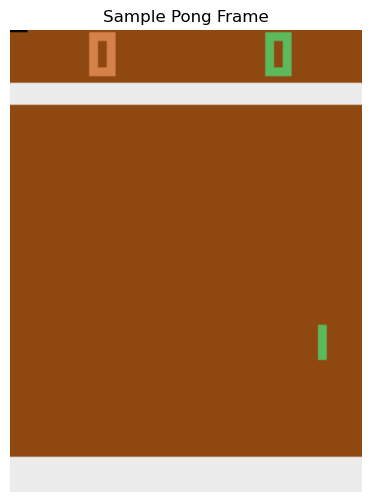

In [25]:
# Get sample frame from Pong
print("Getting sample frame from Pong...")
raw_frame, stacked_frame = get_sample_frame()

print(f"Raw frame shape: {raw_frame.shape}")
print(f"Stacked frame shape: {stacked_frame.shape}")

# Show the raw frame
plt.figure(figsize=(8, 6))
plt.imshow(raw_frame)
plt.title('Sample Pong Frame')
plt.axis('off')
plt.show()

## Find Available Checkpoints

In [26]:
# Find available checkpoints
checkpoints = find_latest_run_checkpoints()

if checkpoints:
    print(f"Found {len(checkpoints)} checkpoints from latest run:")
    for i, cp in enumerate(checkpoints):
        print(f"{i}: {cp['filename']}")
else:
    print("No checkpoints found. Run training first!")

Latest run: run_3fa0a9f9c7ce44bdb33e4e24a44c19b3
Found 8 checkpoints from latest run:
0: pong_dqn_cnn_checkpoint_ep1000.pth
1: pong_dqn_cnn_checkpoint_ep2000.pth
2: pong_dqn_cnn_checkpoint_ep3000.pth
3: pong_dqn_cnn_checkpoint_ep4000.pth
4: pong_dqn_cnn_checkpoint_ep5000.pth
5: pong_dqn_cnn_checkpoint_ep6000.pth
6: pong_dqn_cnn_checkpoint_ep7000.pth
7: pong_dqn_cnn_checkpoint_ep8000.pth


## Visualize CNN Layers for All Checkpoints


CHECKPOINT 1/8: pong_dqn_cnn_checkpoint_ep1000.pth
Training Episode: 1000
Training Avg Reward: -20.7

Visualizing layers for pong_dqn_cnn_checkpoint_ep1000.pth


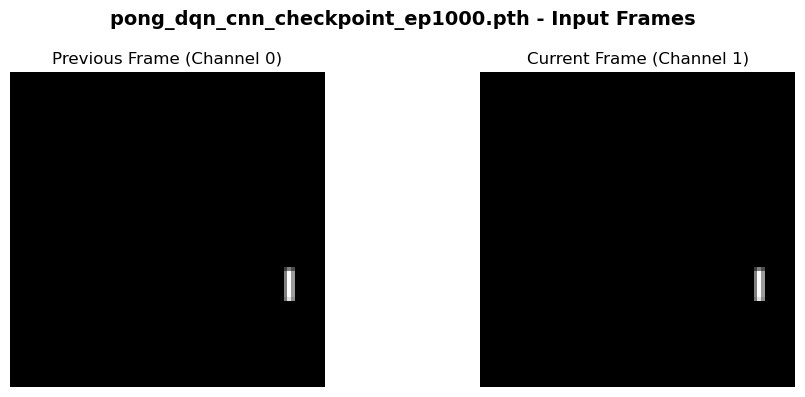

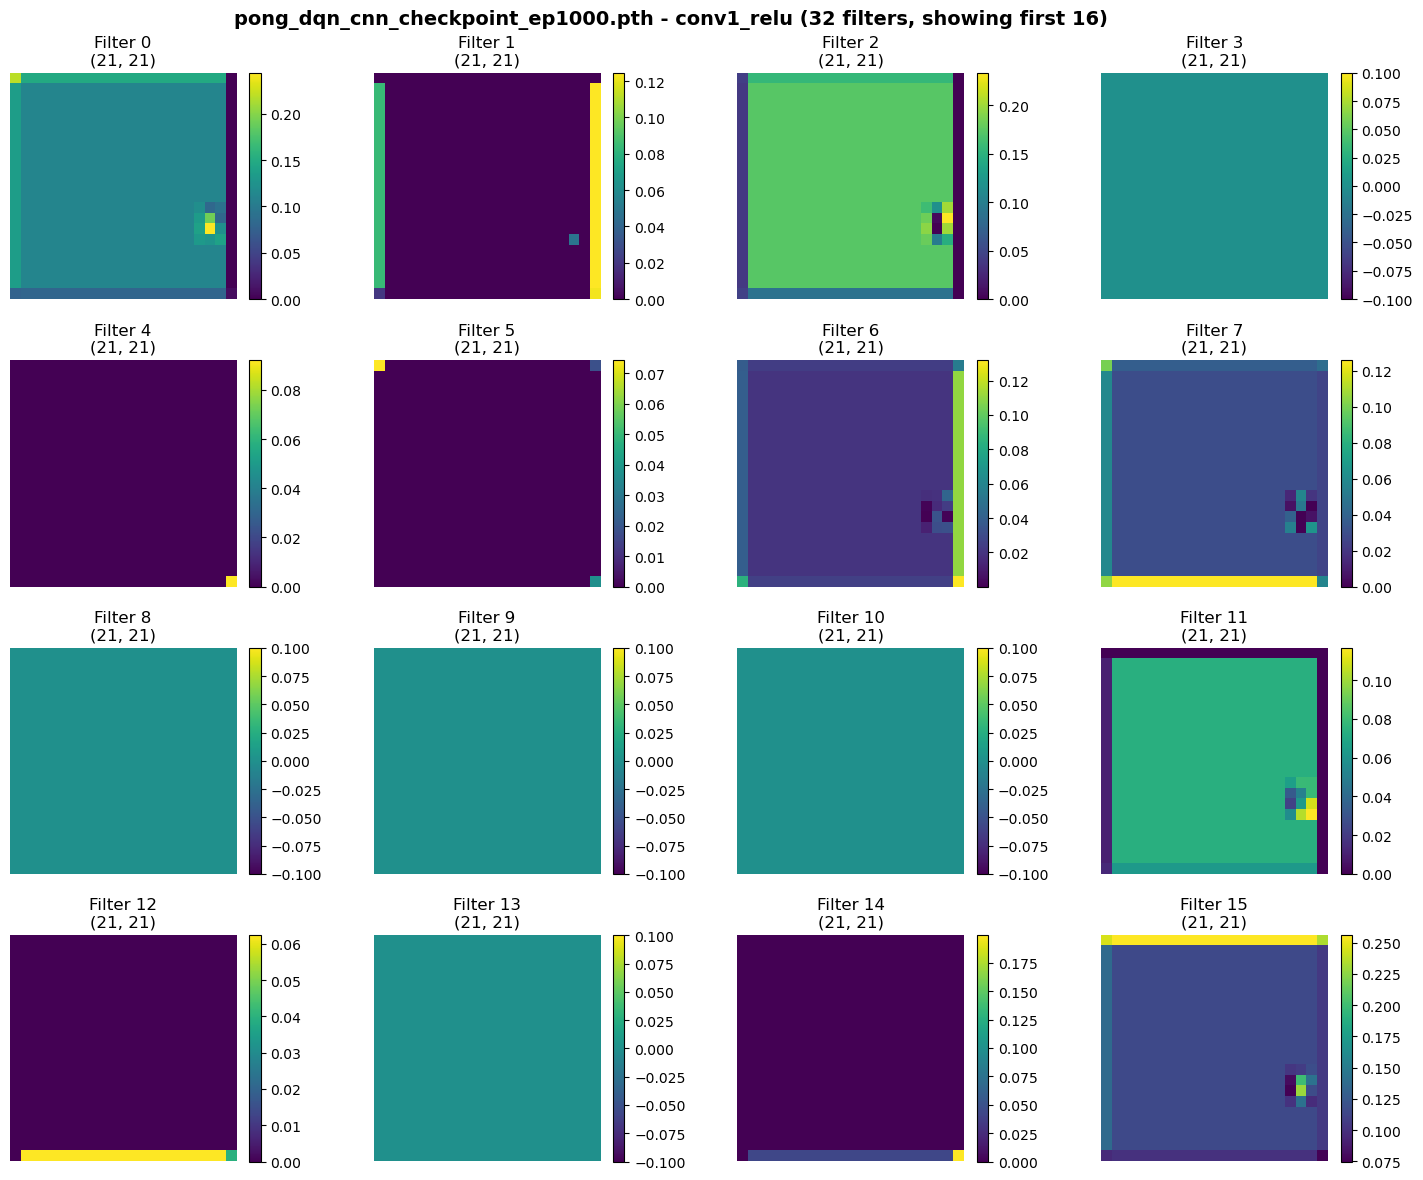

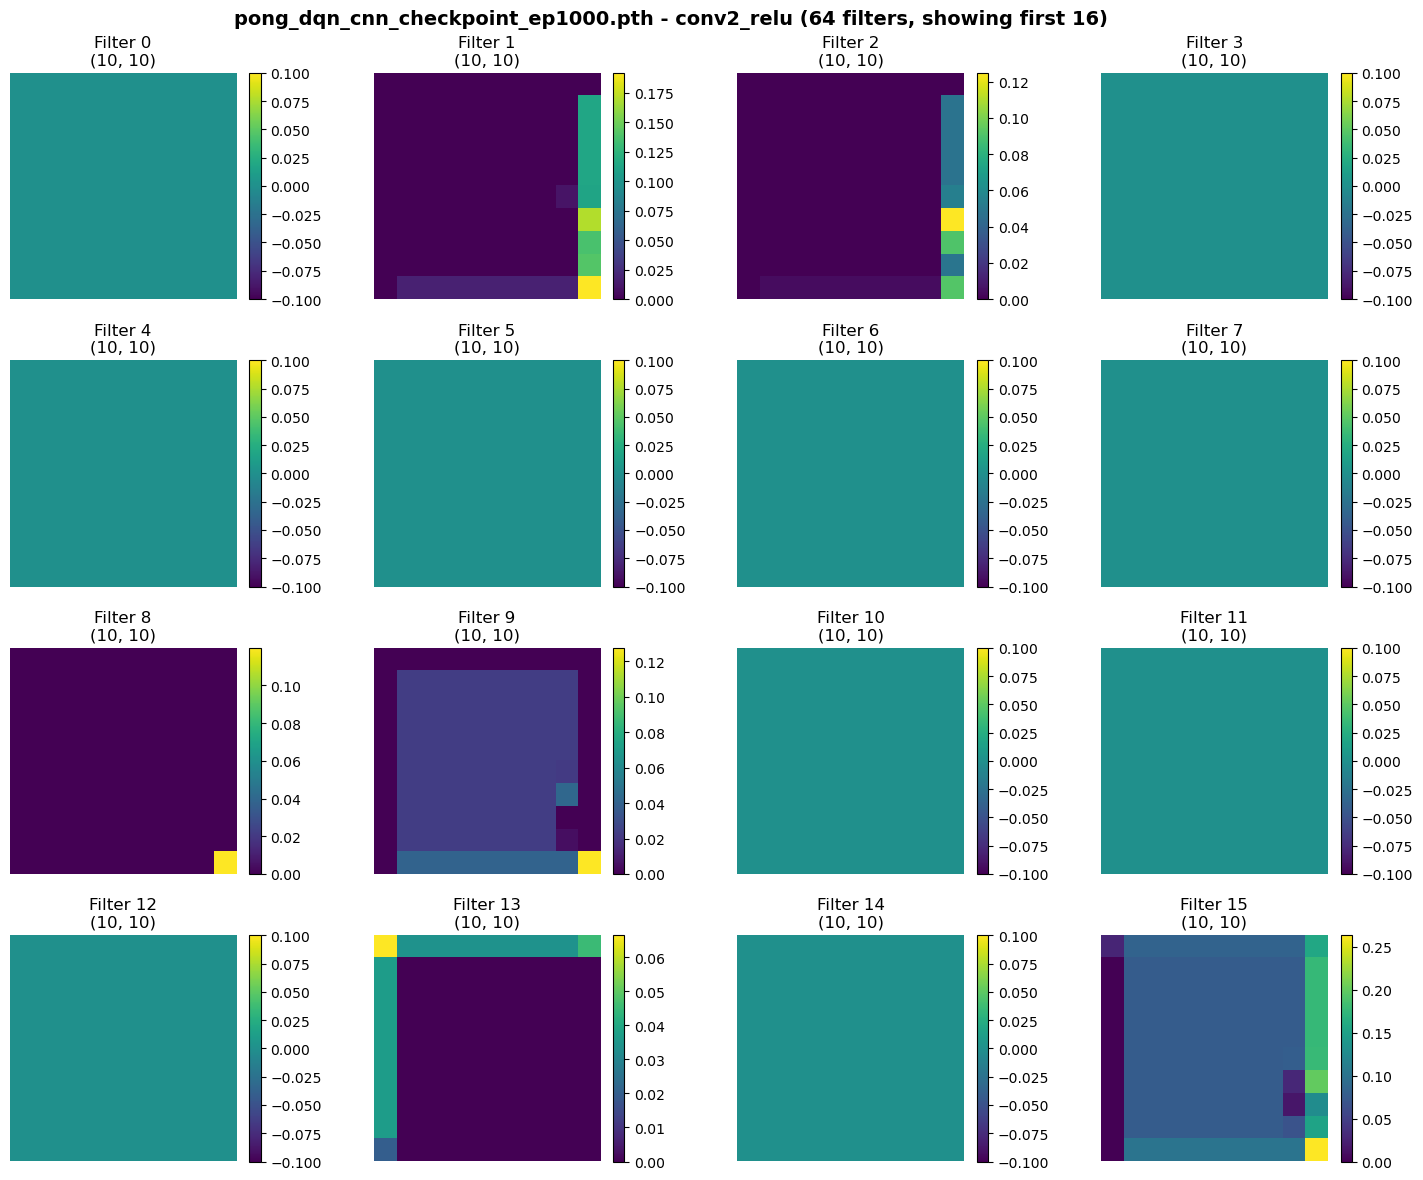

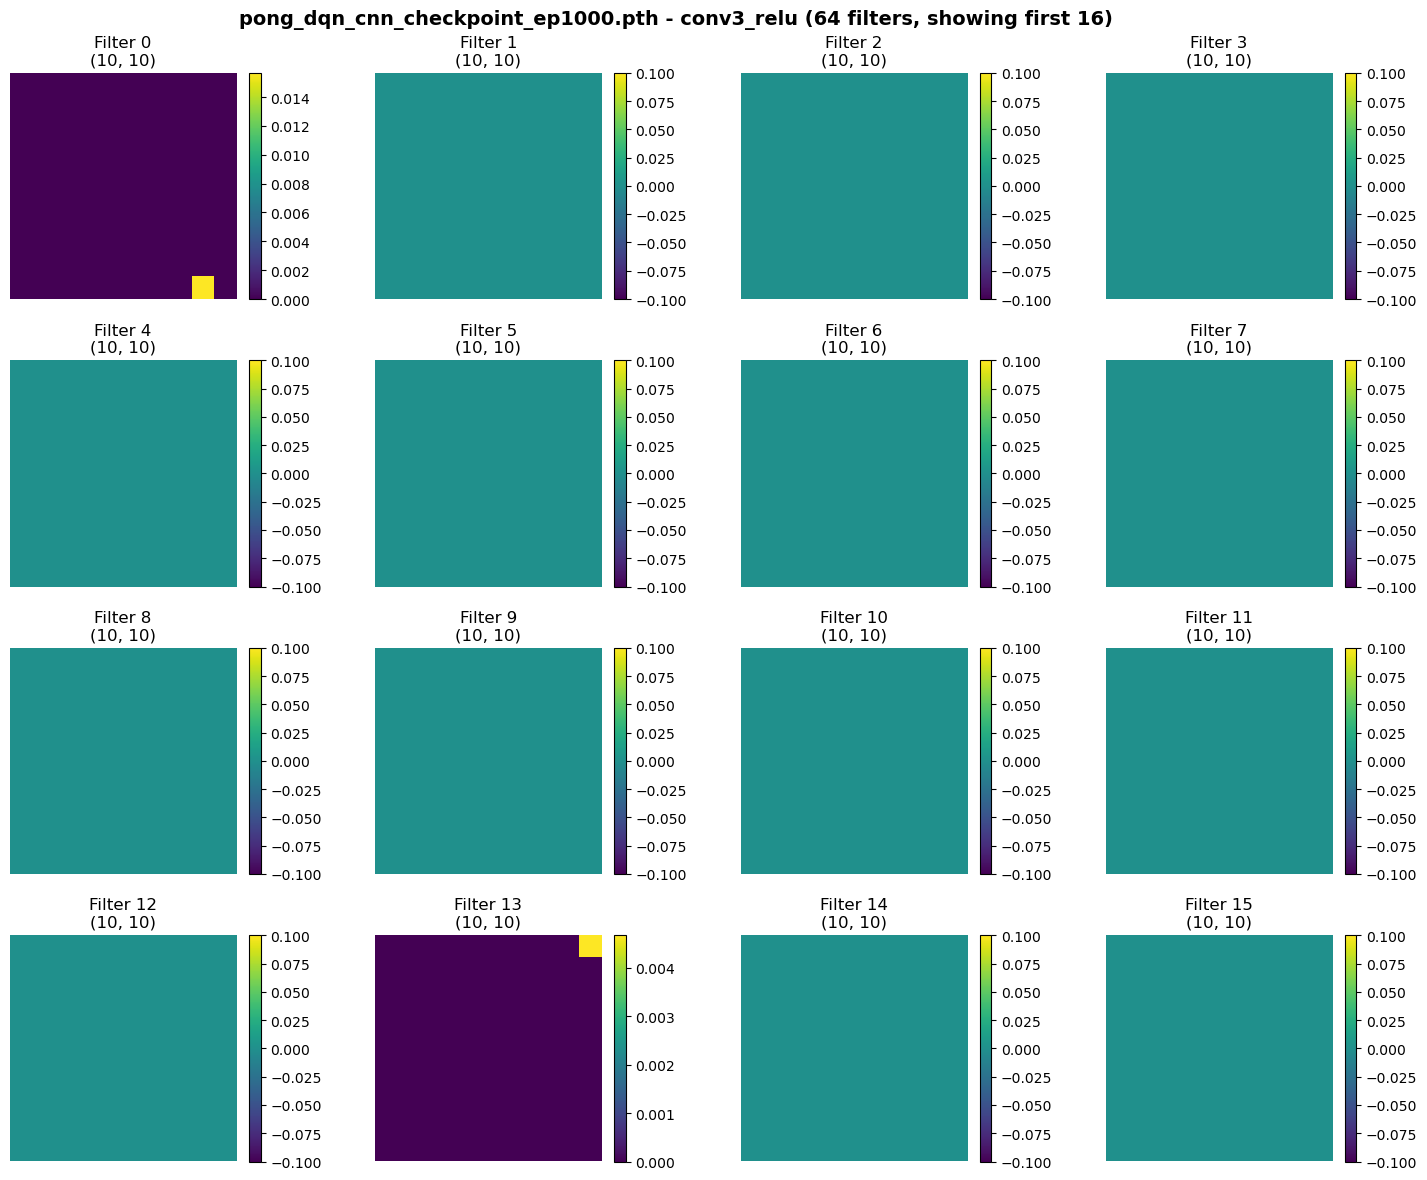


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.023 | Max:  0.256 | Sparsity: 0.722
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.008 | Max:  0.263 | Sparsity: 0.878
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.016 | Sparsity: 0.999

CHECKPOINT 2/8: pong_dqn_cnn_checkpoint_ep2000.pth
Training Episode: 2000
Training Avg Reward: -20.8

Visualizing layers for pong_dqn_cnn_checkpoint_ep2000.pth


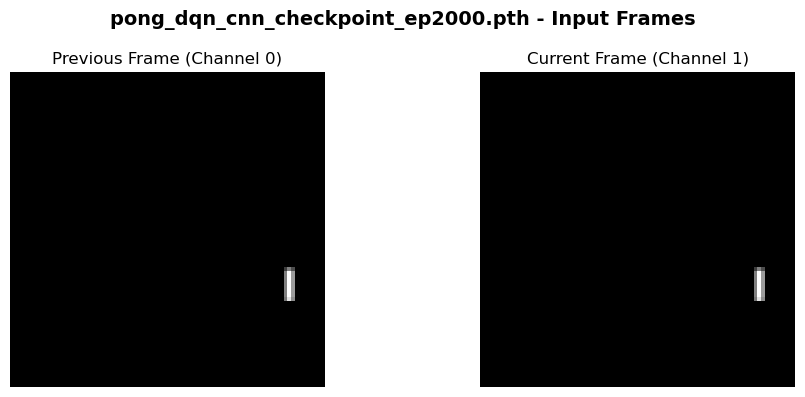

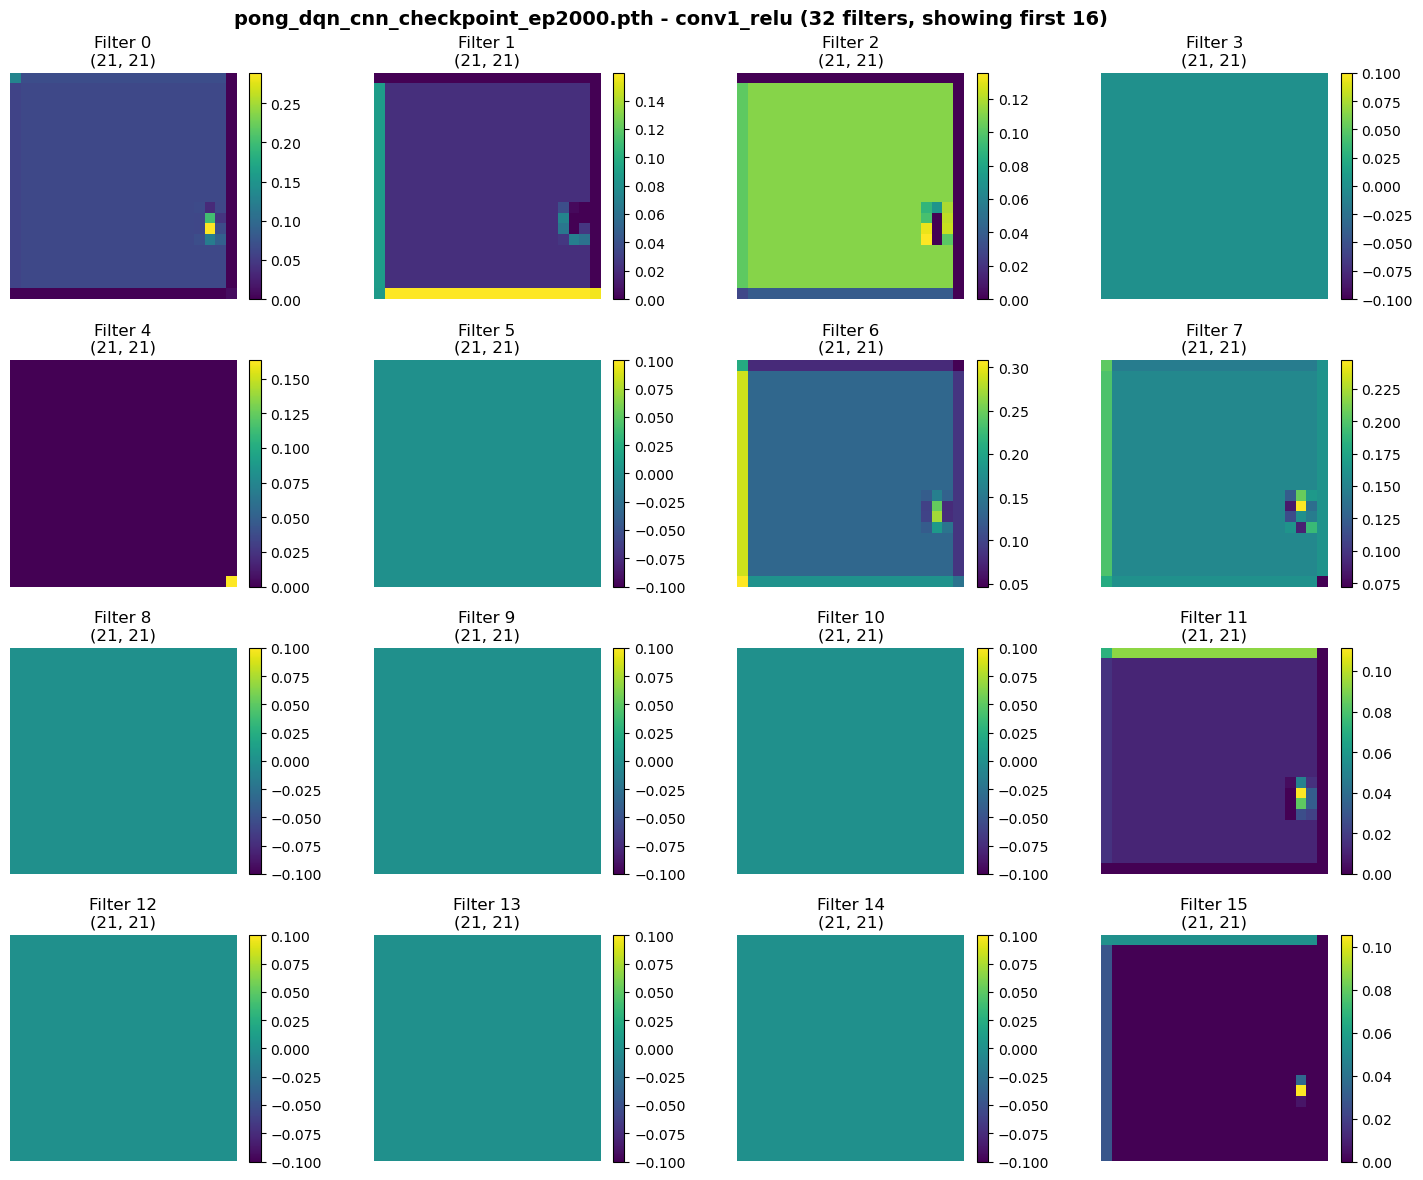

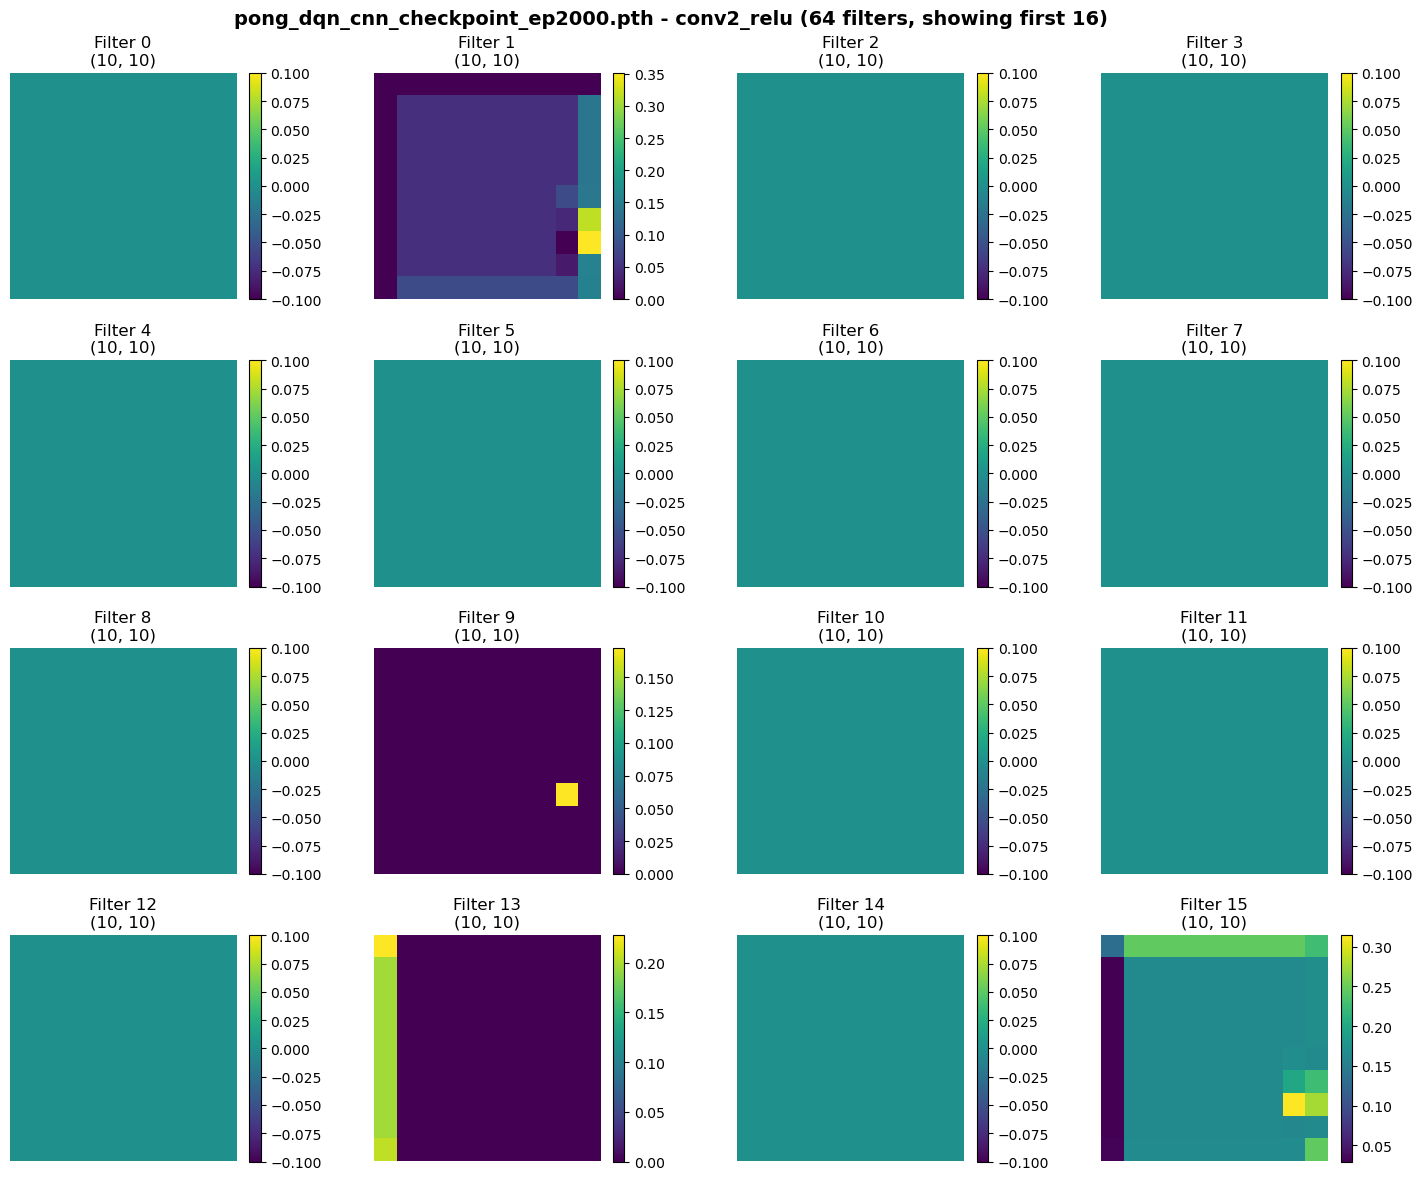

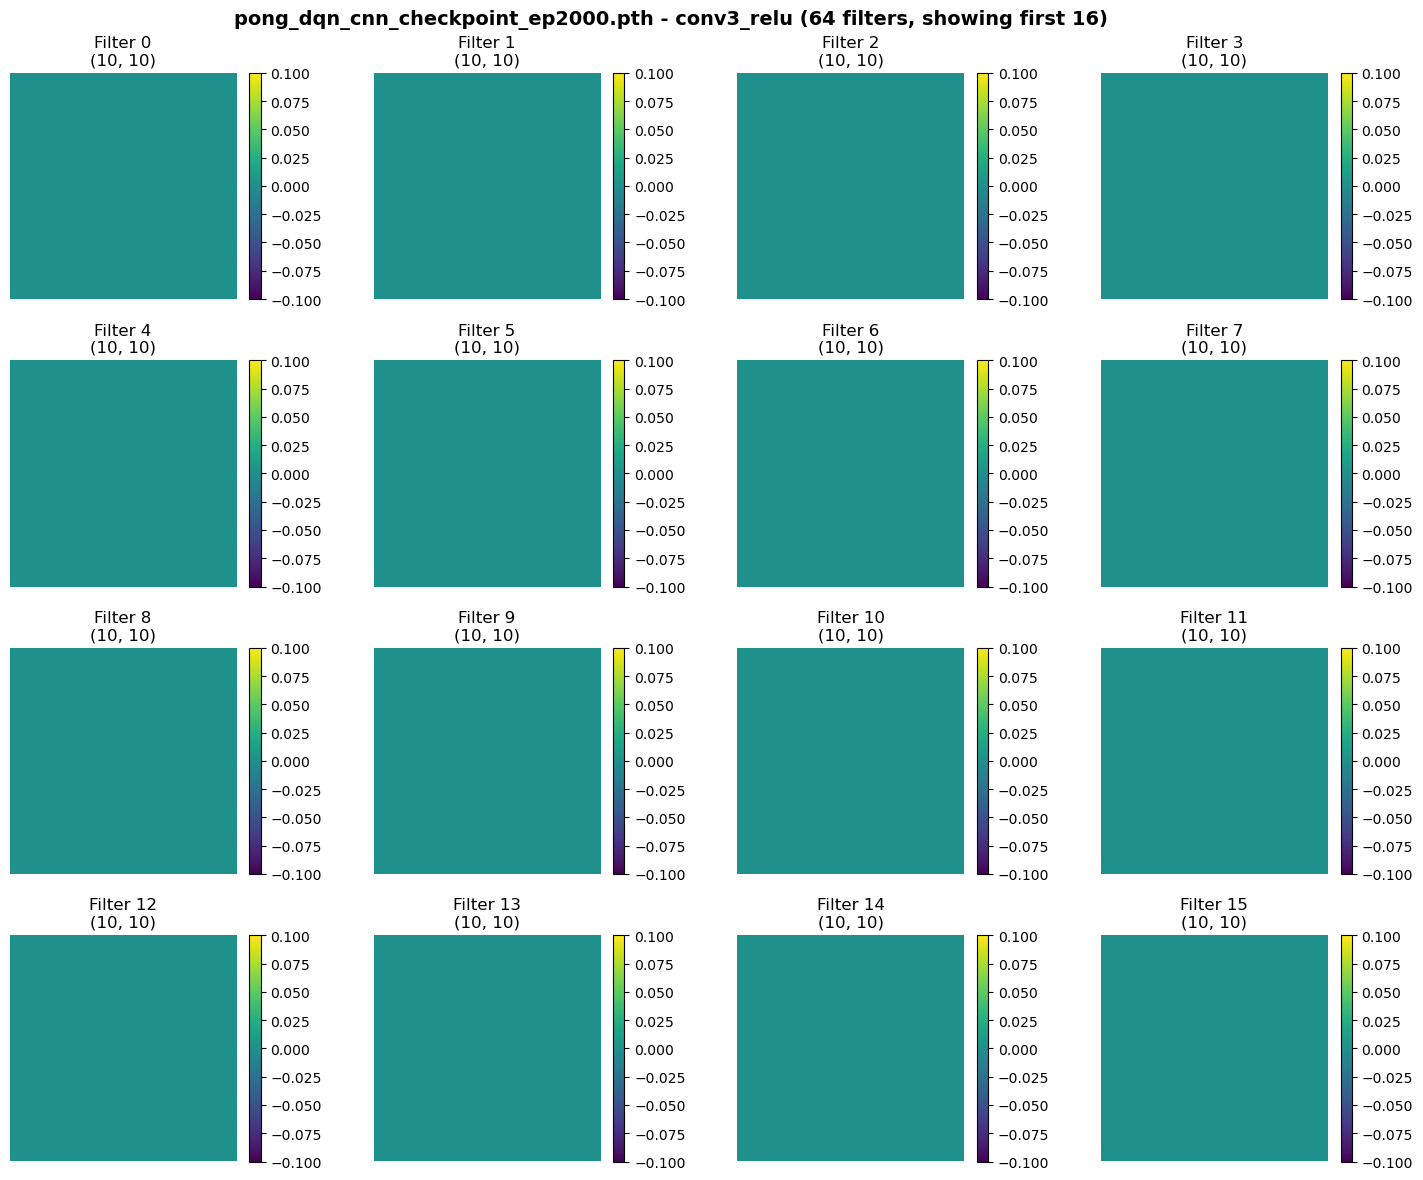


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.025 | Max:  0.308 | Sparsity: 0.701
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.009 | Max:  0.387 | Sparsity: 0.884
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.013 | Sparsity: 1.000

CHECKPOINT 3/8: pong_dqn_cnn_checkpoint_ep3000.pth
Training Episode: 3000
Training Avg Reward: -19.8

Visualizing layers for pong_dqn_cnn_checkpoint_ep3000.pth


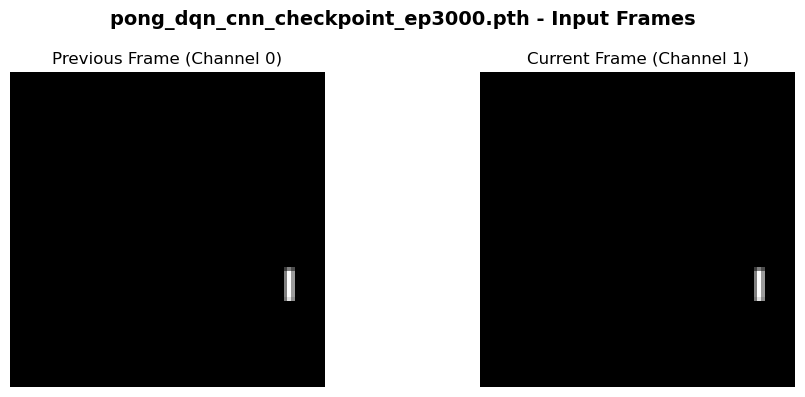

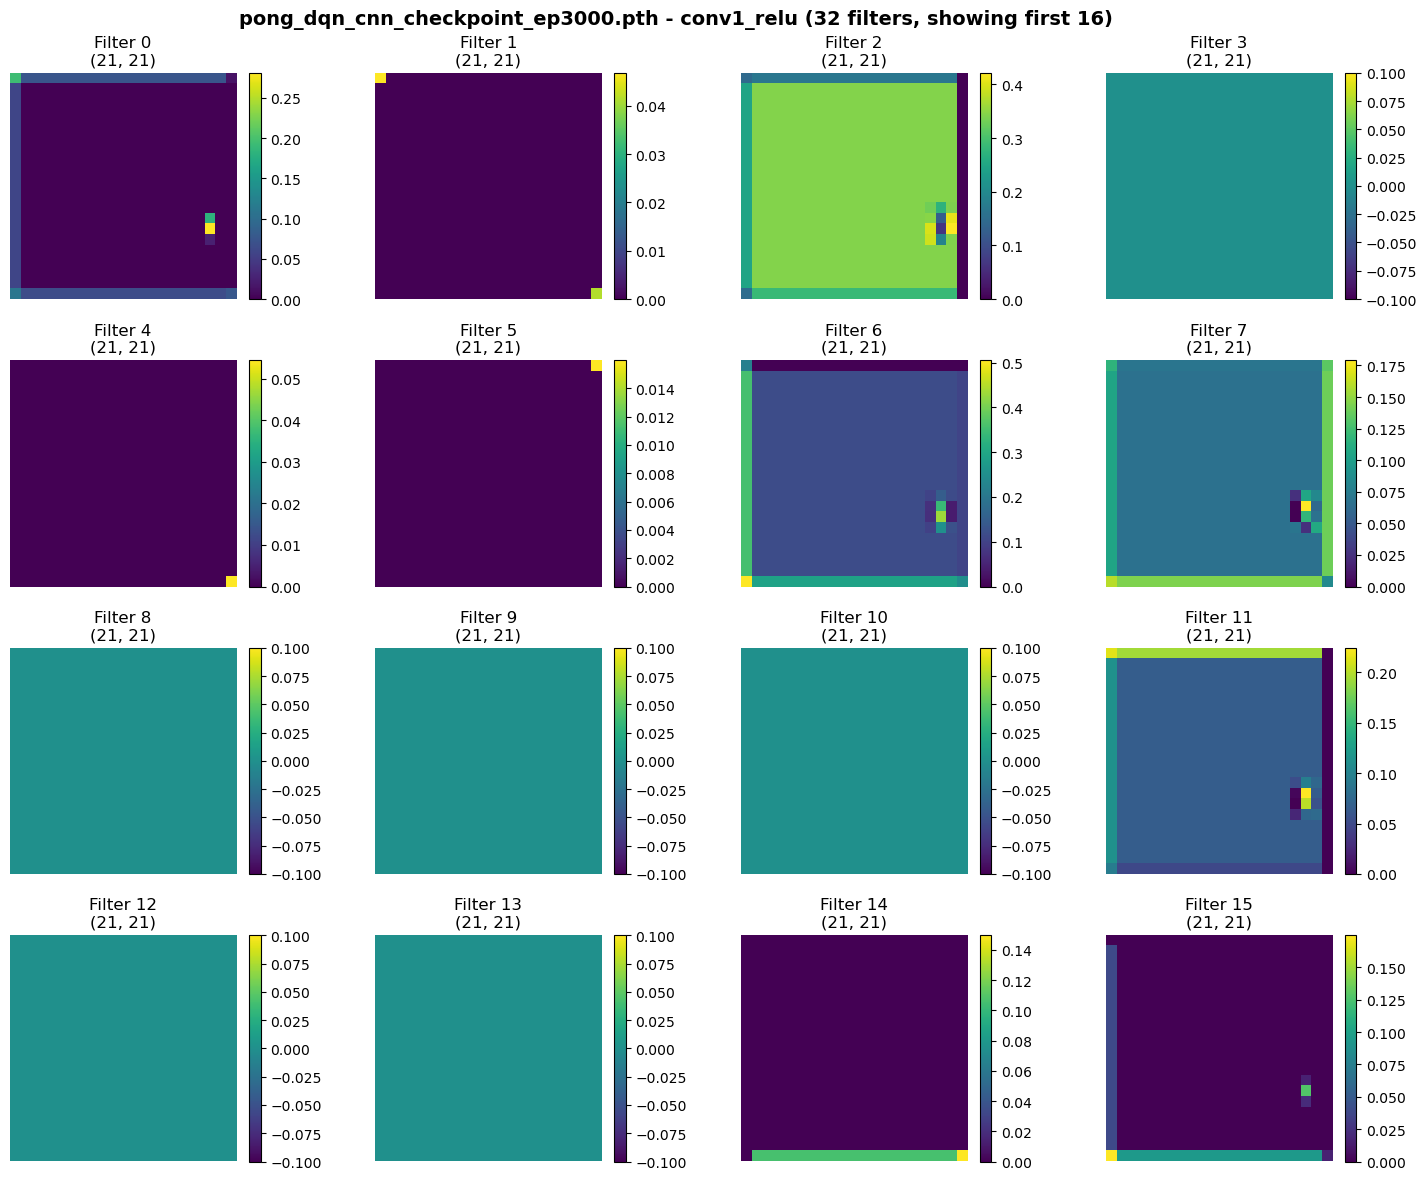

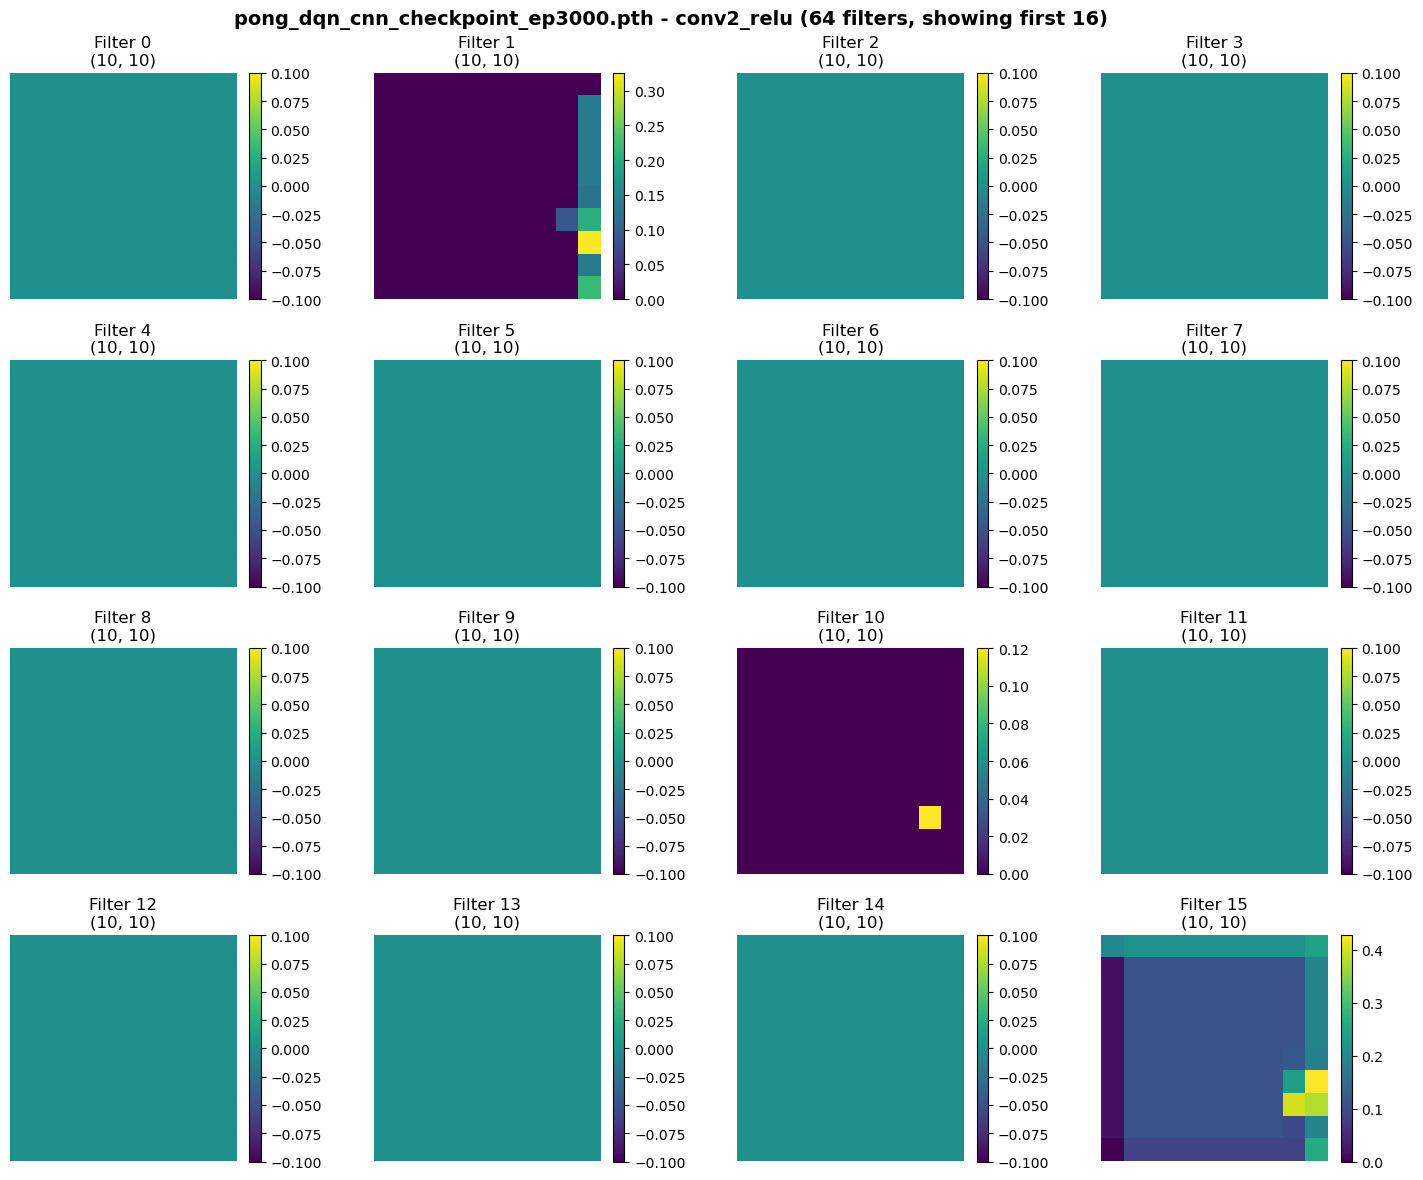

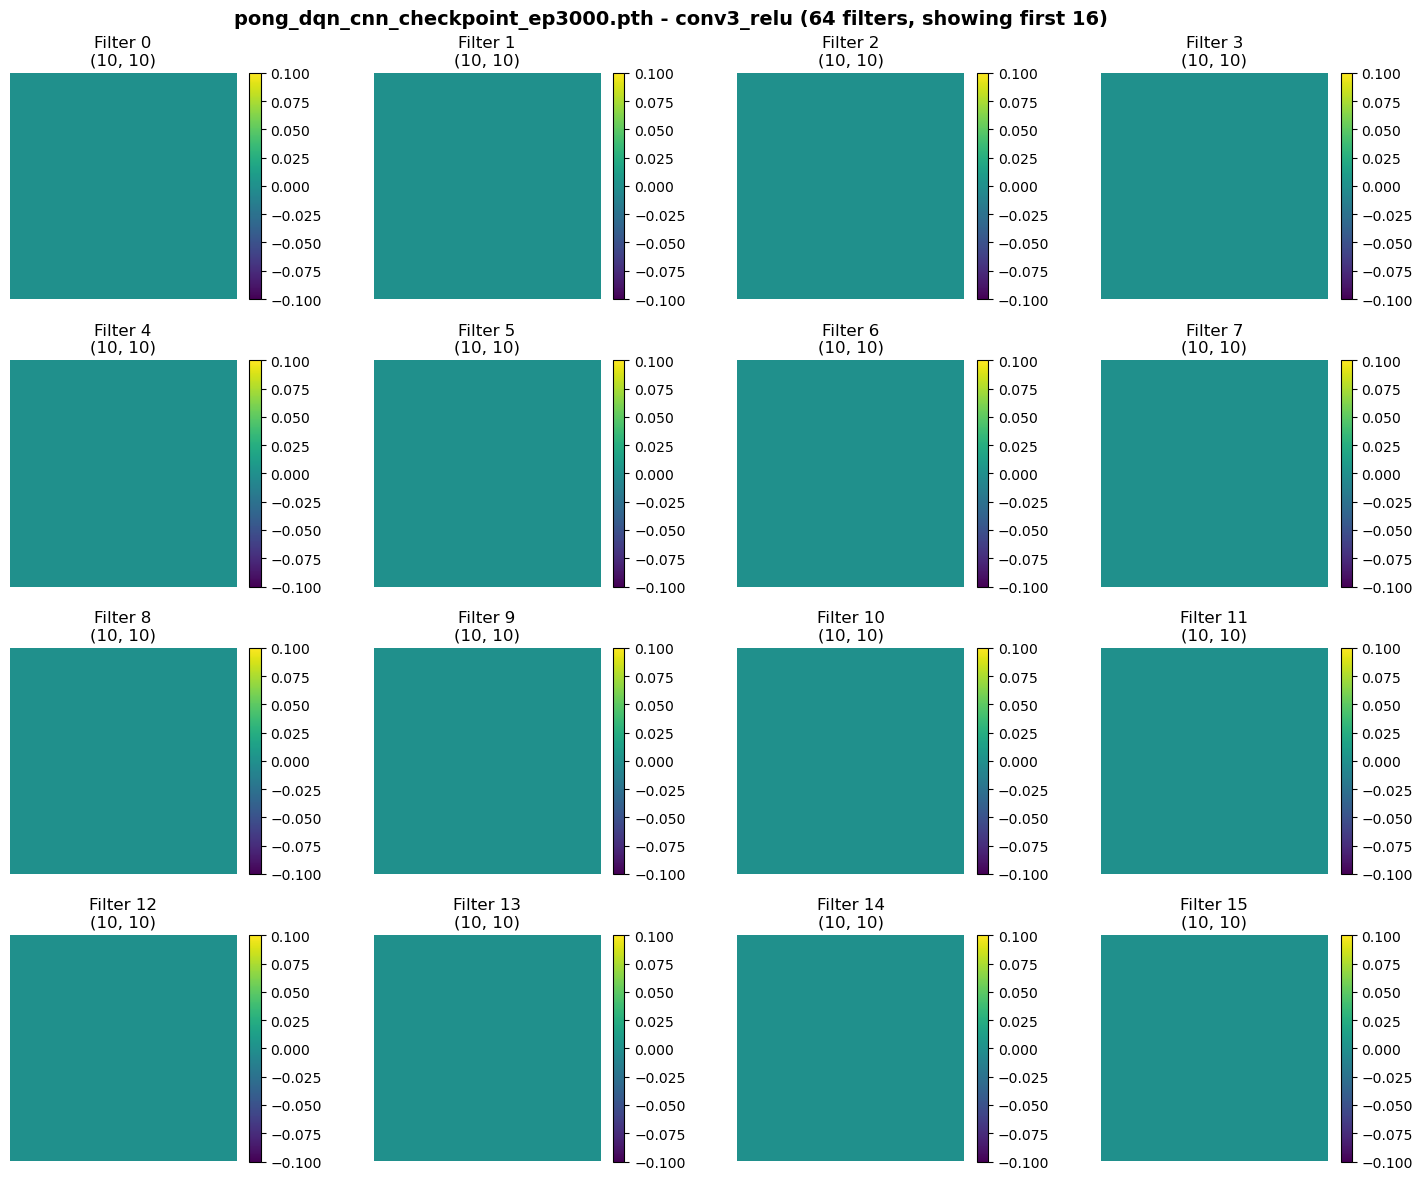


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.032 | Max:  0.506 | Sparsity: 0.804
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.008 | Max:  0.751 | Sparsity: 0.935
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.000 | Sparsity: 1.000

CHECKPOINT 4/8: pong_dqn_cnn_checkpoint_ep4000.pth
Training Episode: 4000
Training Avg Reward: -20.3

Visualizing layers for pong_dqn_cnn_checkpoint_ep4000.pth


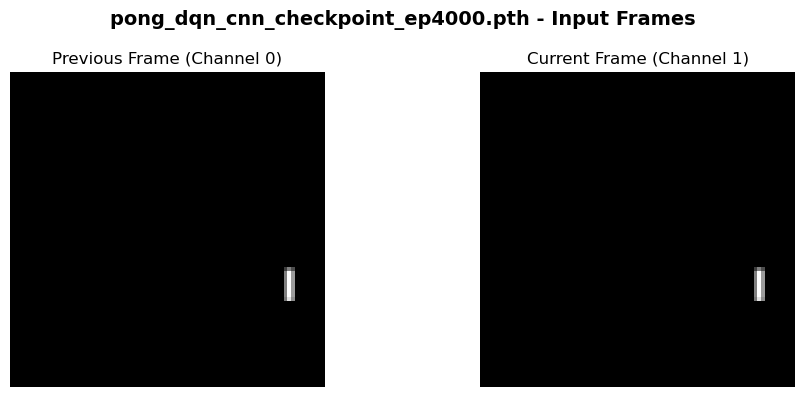

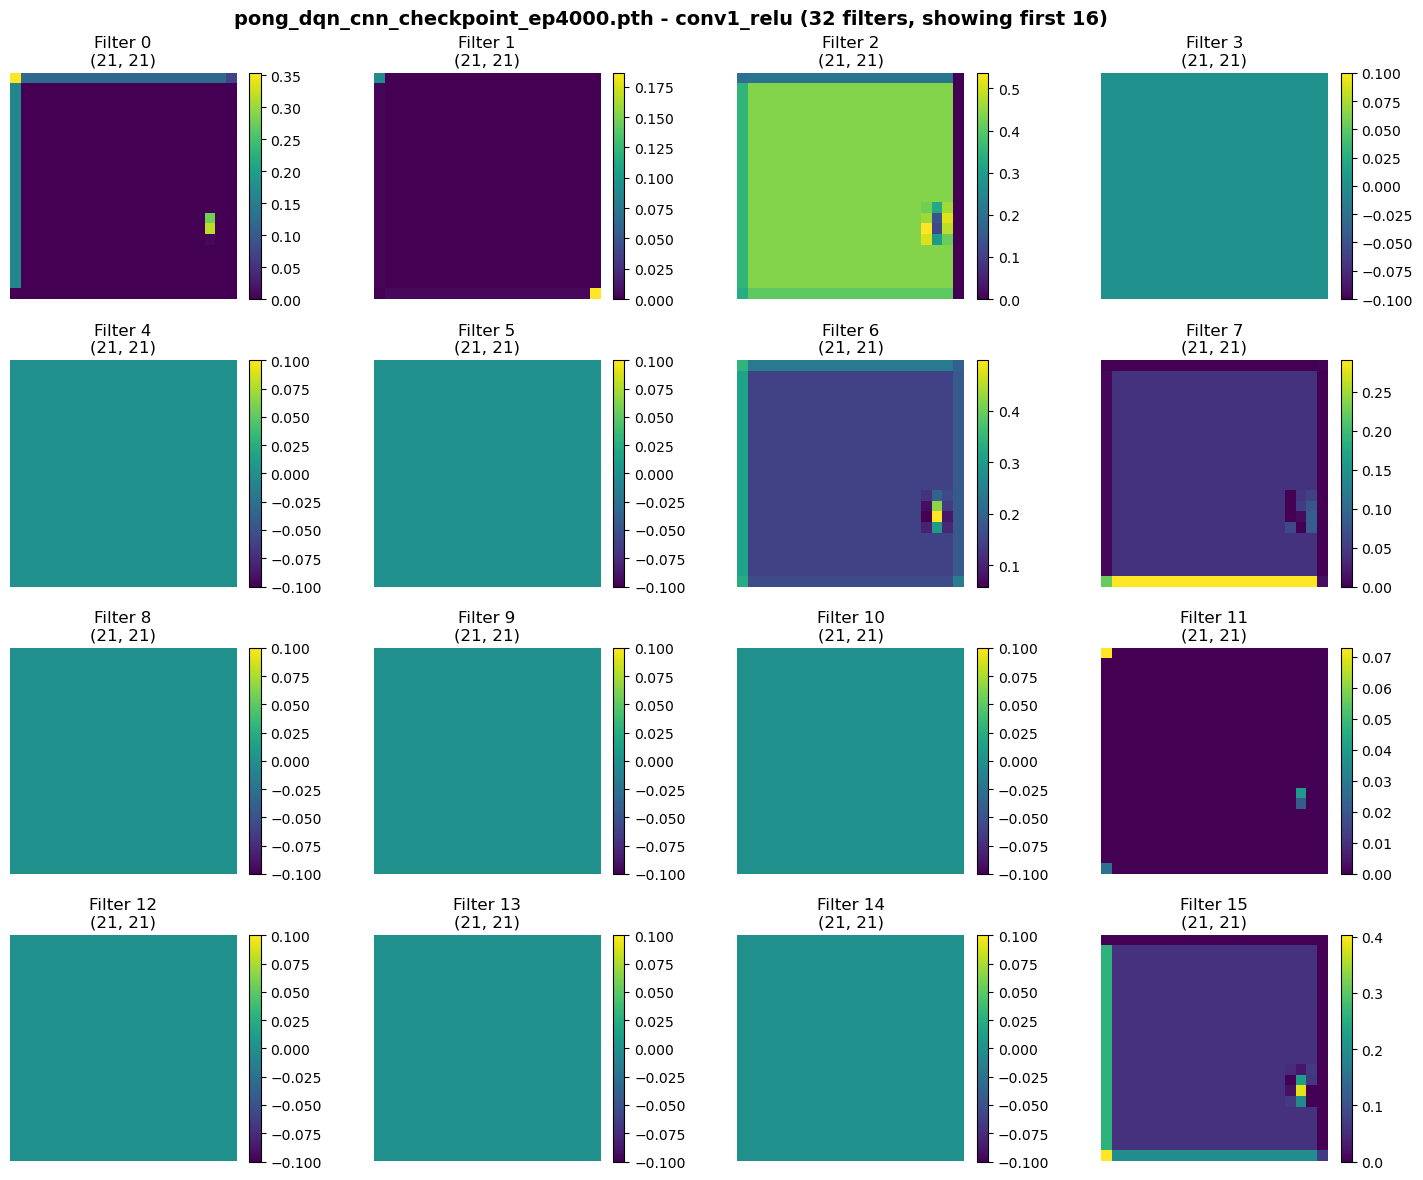

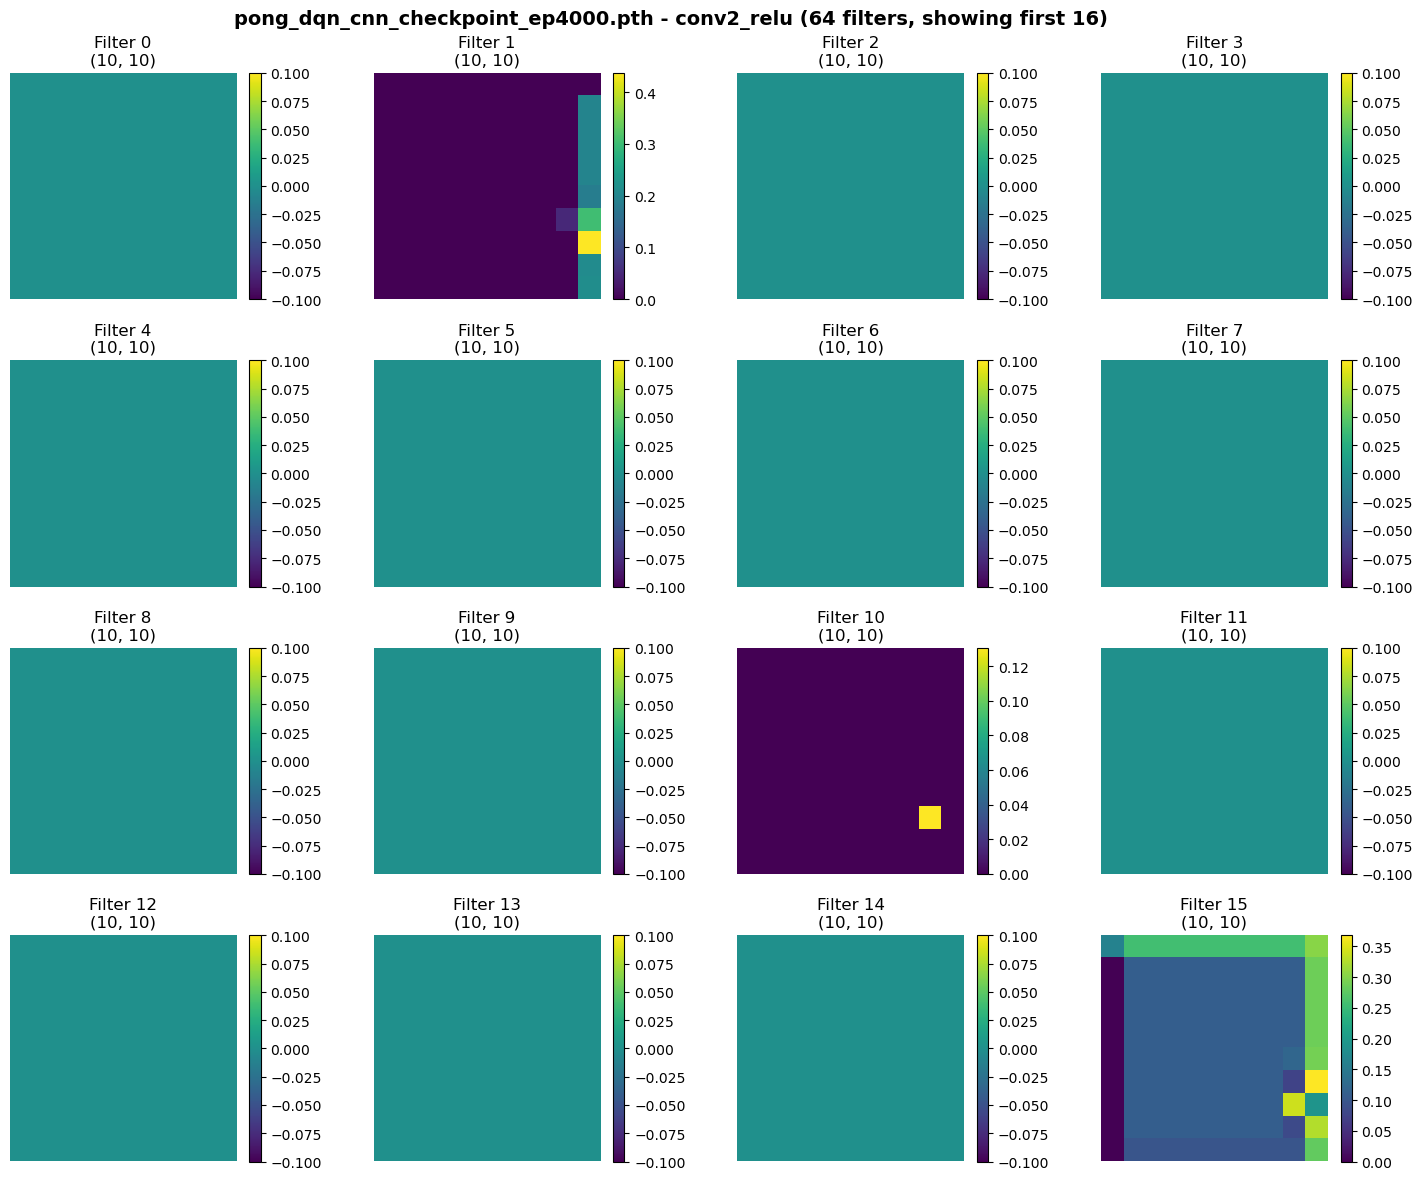

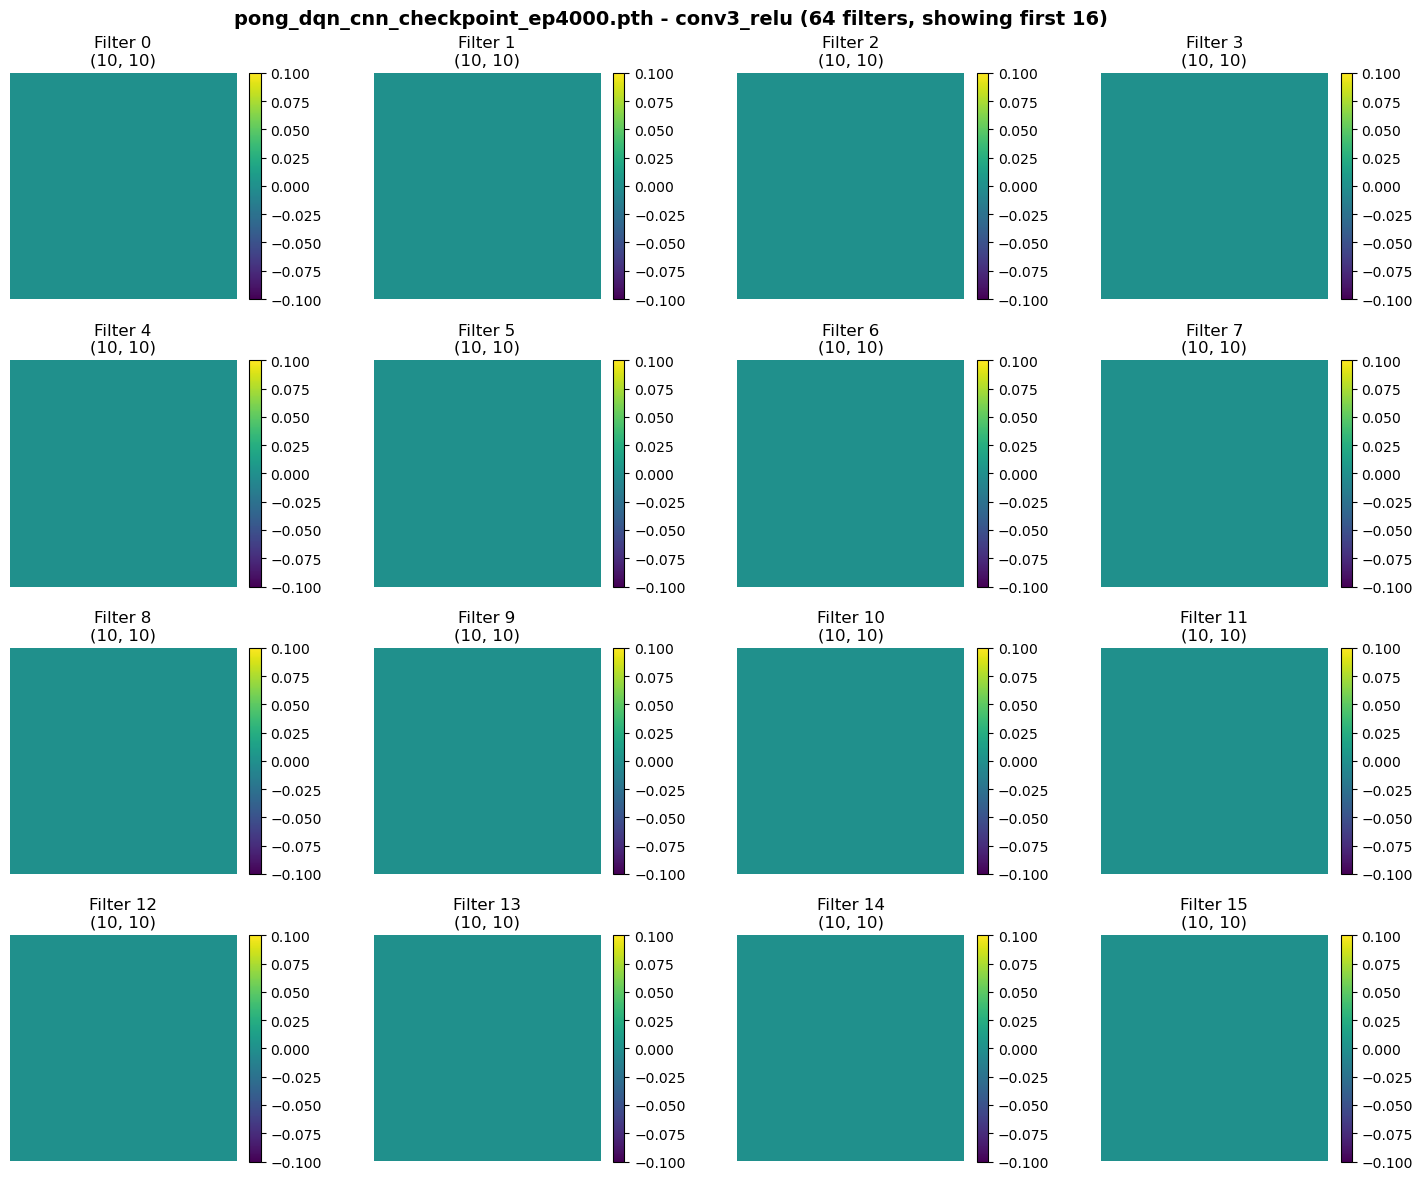


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.034 | Max:  0.726 | Sparsity: 0.818
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.009 | Max:  0.696 | Sparsity: 0.946
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.001 | Sparsity: 1.000

CHECKPOINT 5/8: pong_dqn_cnn_checkpoint_ep5000.pth
Training Episode: 5000
Training Avg Reward: -19.9

Visualizing layers for pong_dqn_cnn_checkpoint_ep5000.pth


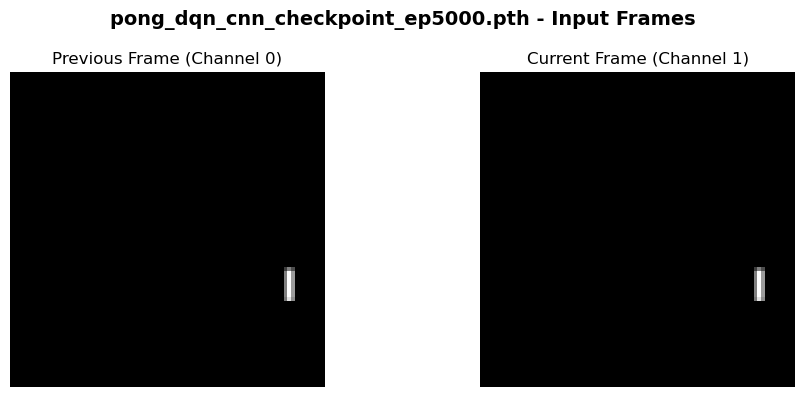

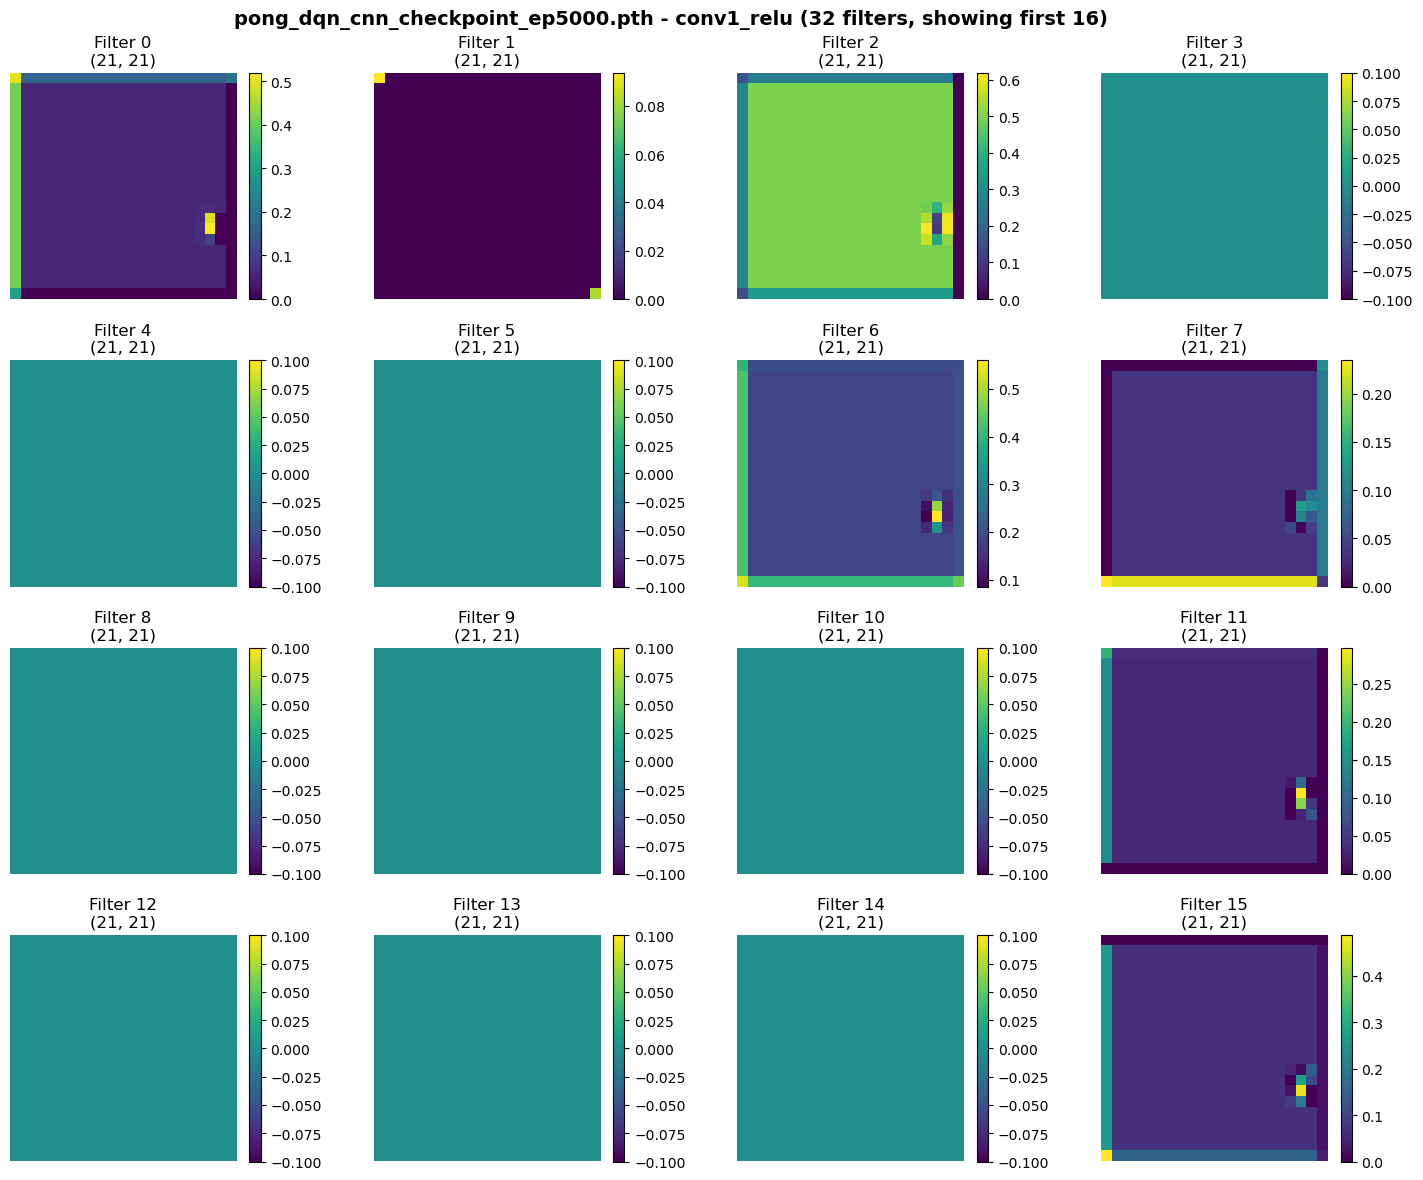

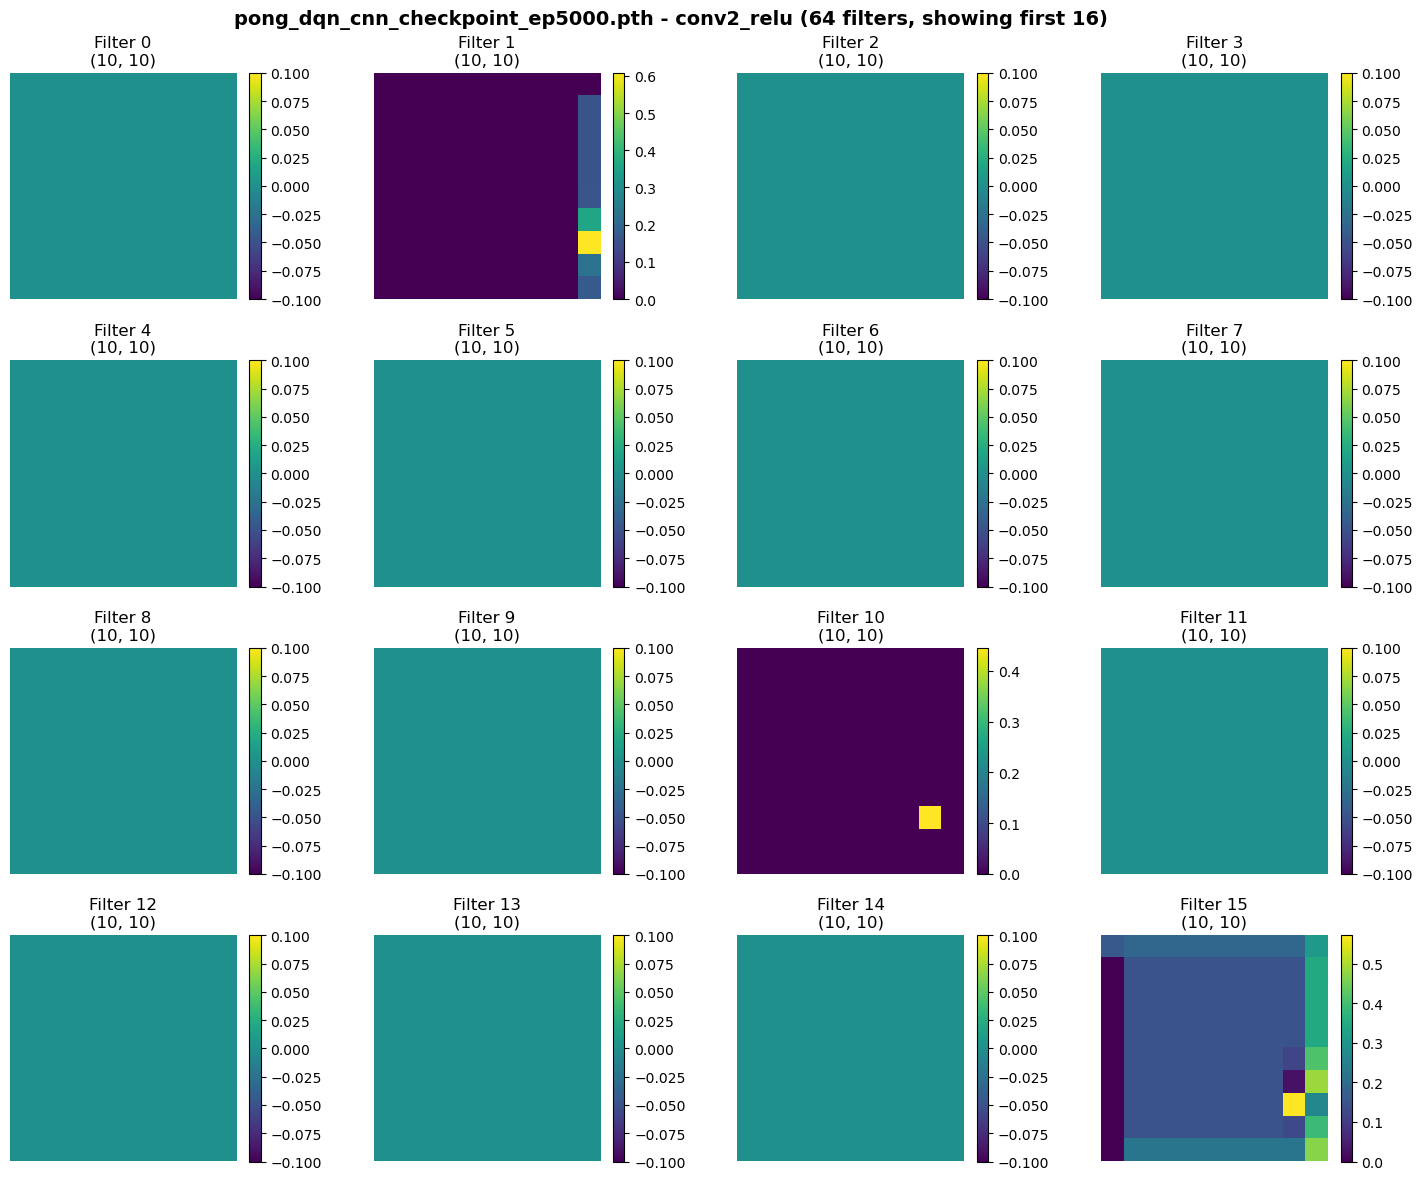

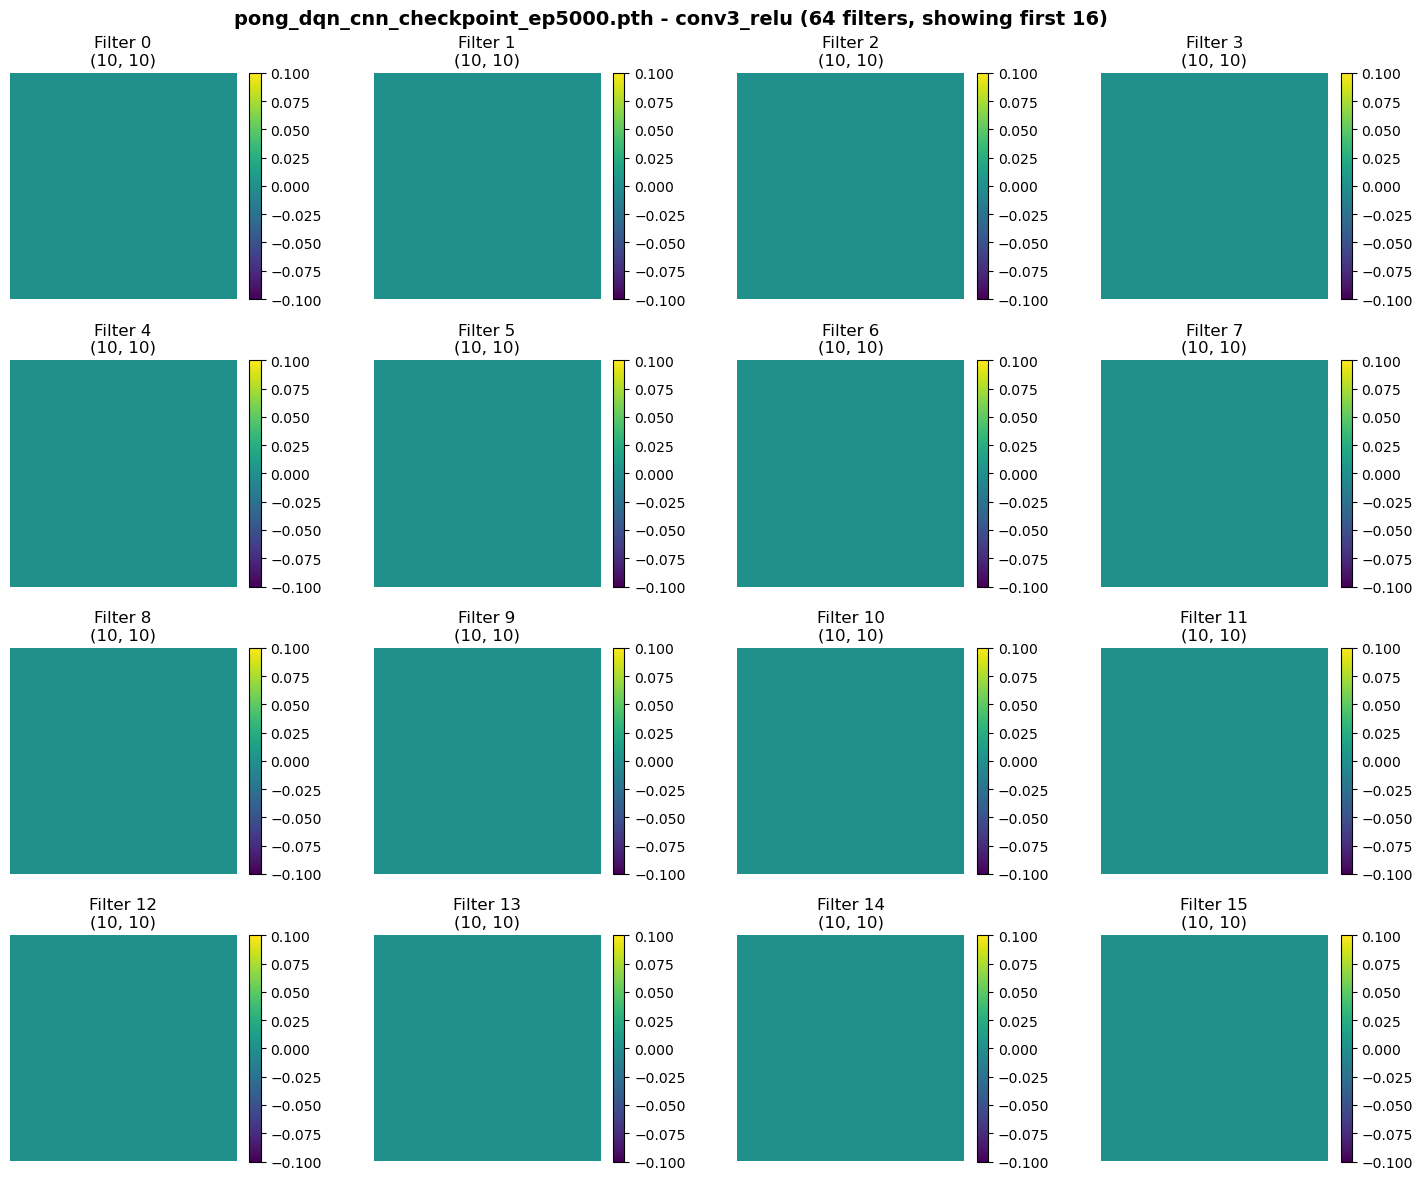


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.040 | Max:  0.856 | Sparsity: 0.764
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.009 | Max:  0.991 | Sparsity: 0.949
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.046 | Sparsity: 1.000

CHECKPOINT 6/8: pong_dqn_cnn_checkpoint_ep6000.pth
Training Episode: 6000
Training Avg Reward: -19.6

Visualizing layers for pong_dqn_cnn_checkpoint_ep6000.pth


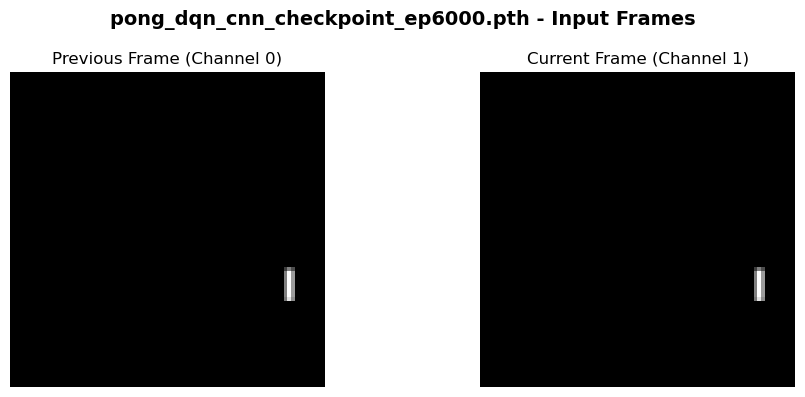

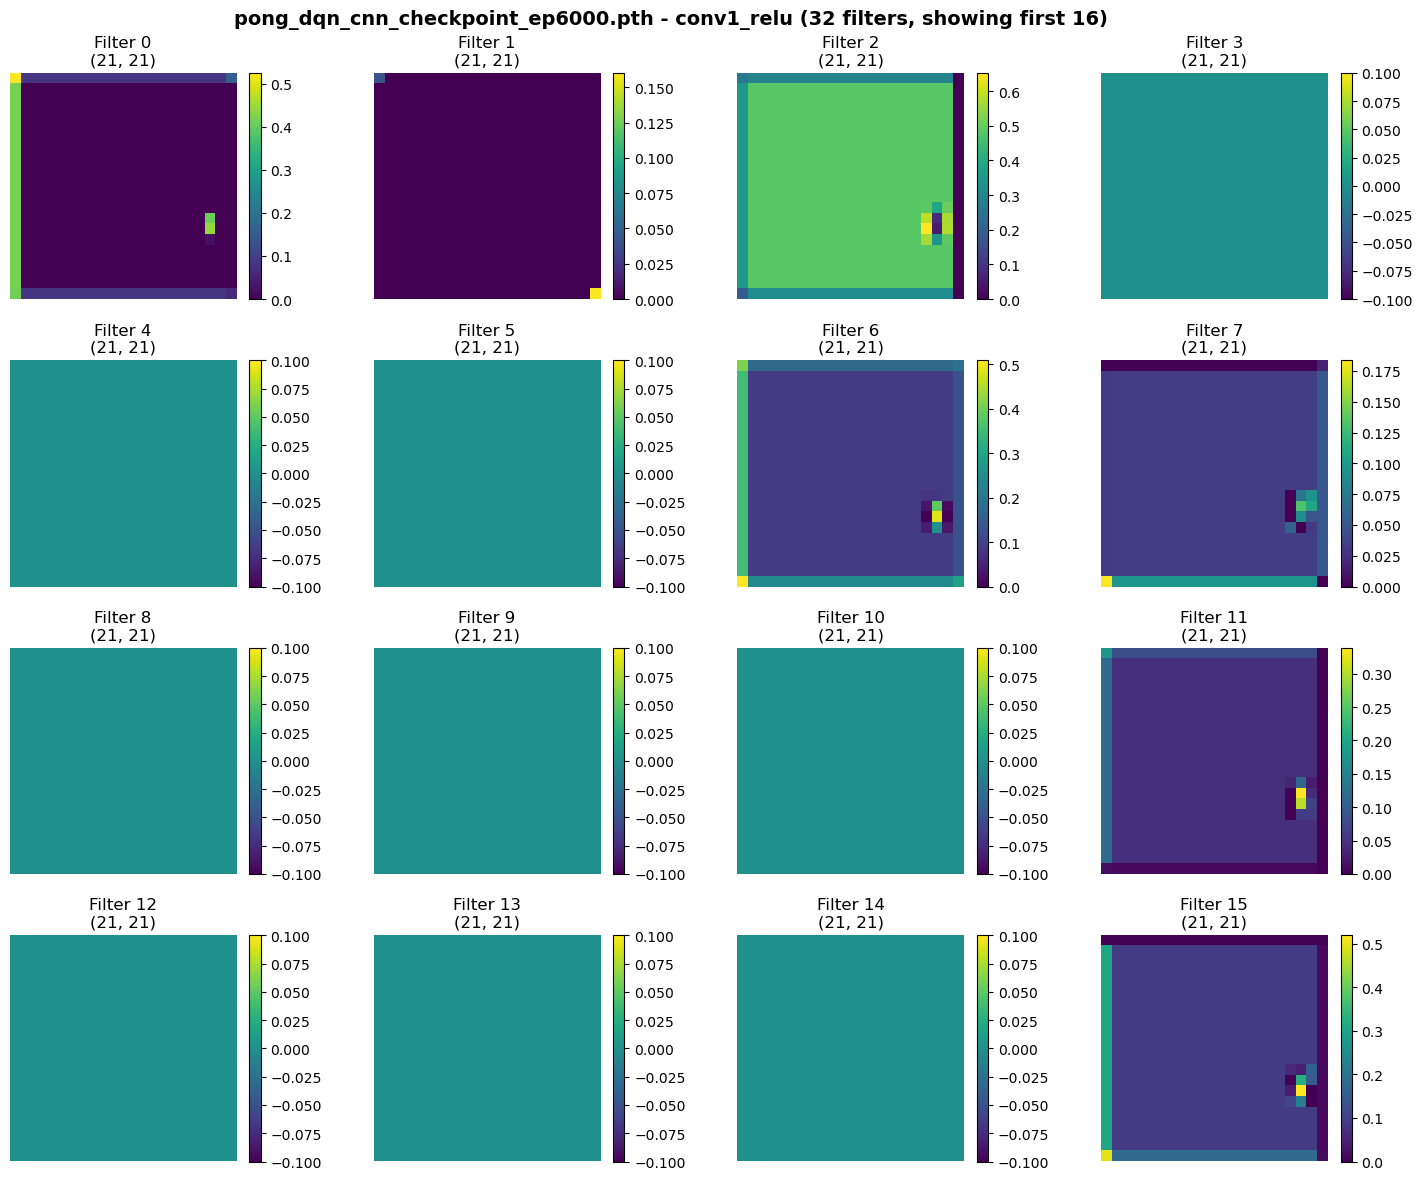

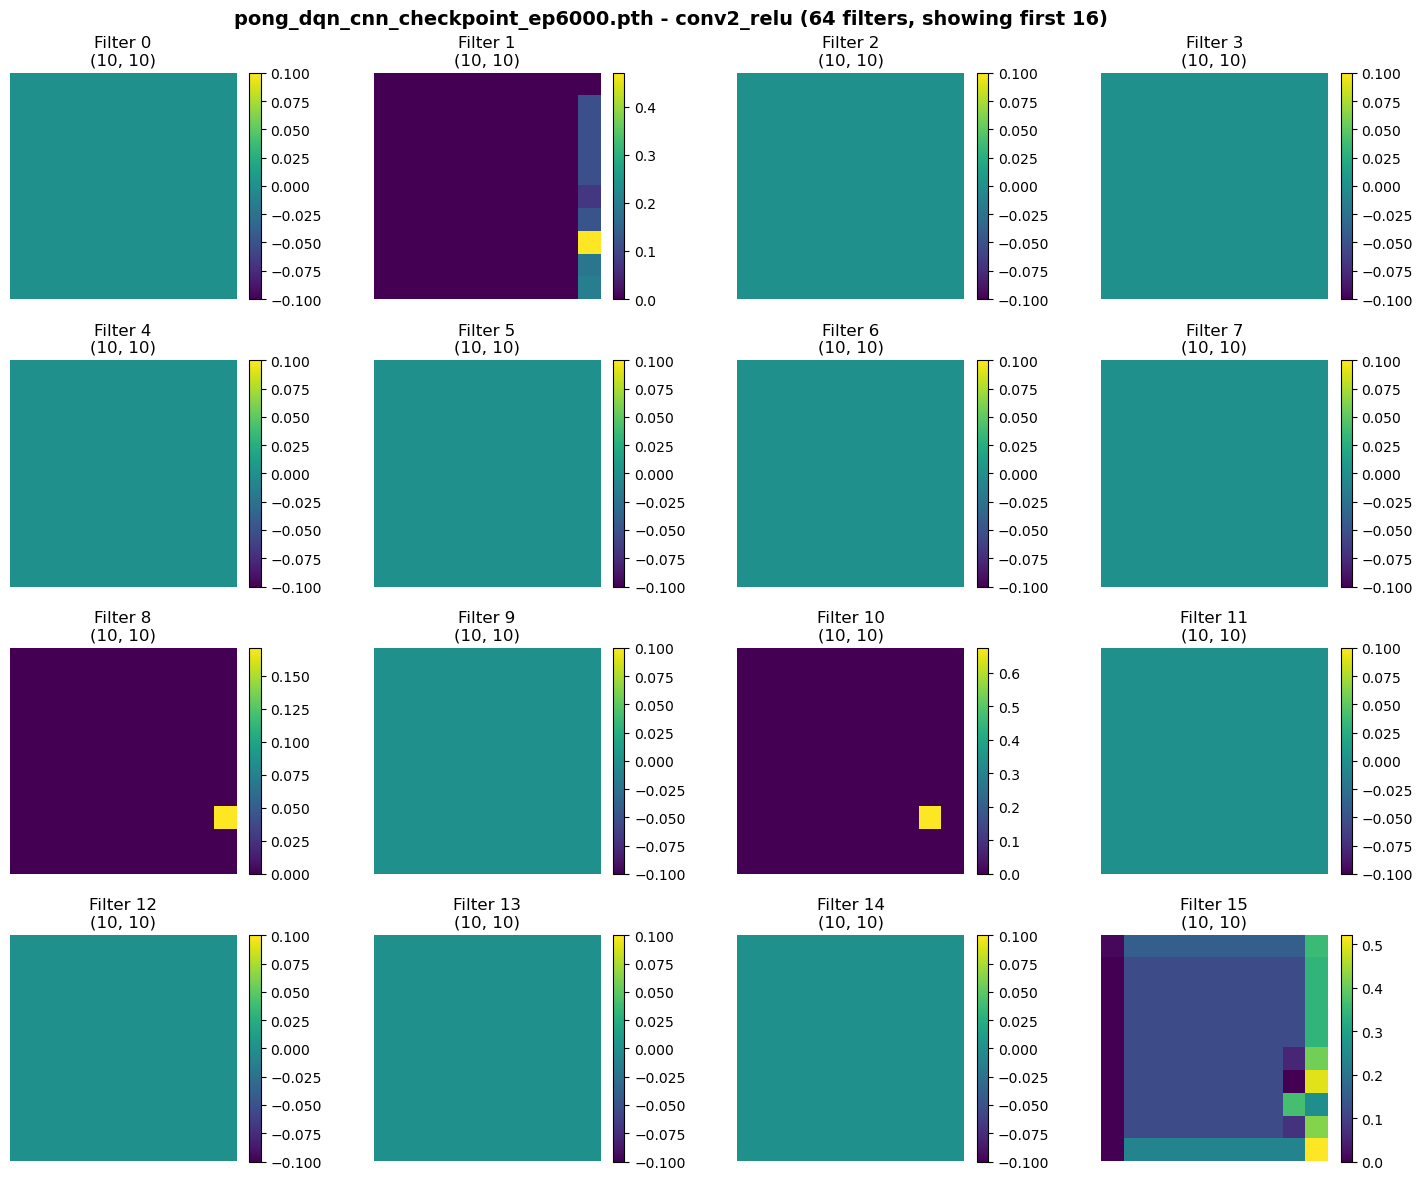

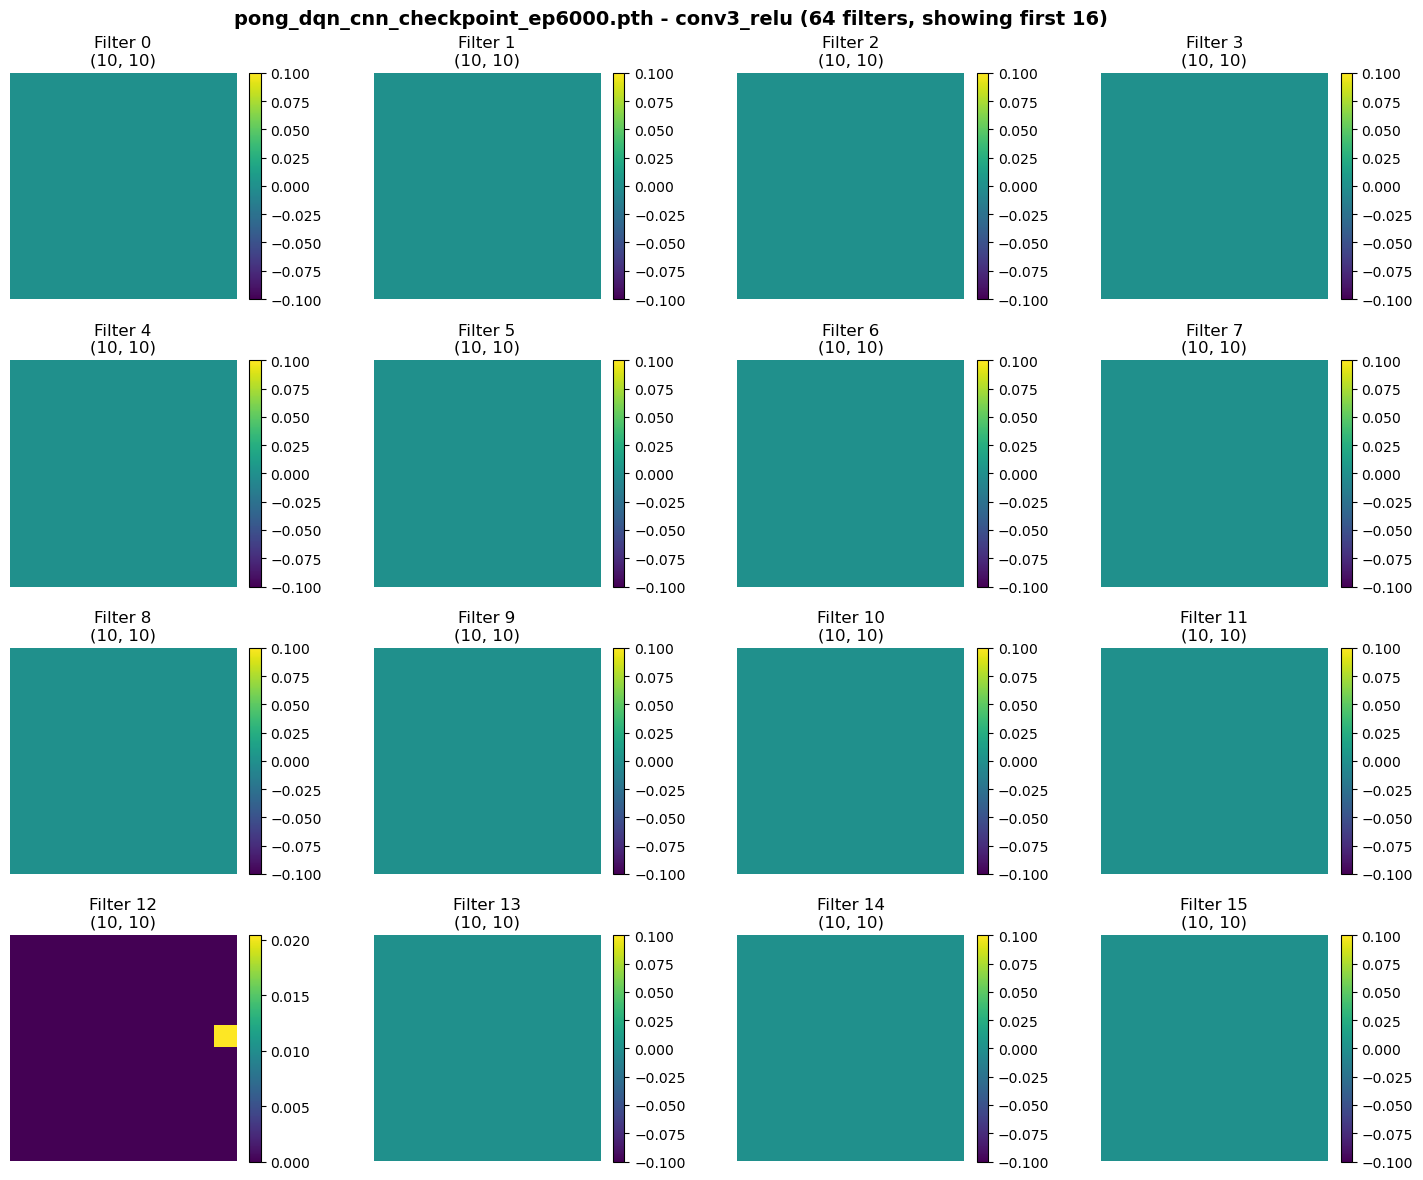


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.036 | Max:  0.853 | Sparsity: 0.783
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.008 | Max:  1.108 | Sparsity: 0.949
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.048 | Sparsity: 0.999

CHECKPOINT 7/8: pong_dqn_cnn_checkpoint_ep7000.pth
Training Episode: 7000
Training Avg Reward: -17.5

Visualizing layers for pong_dqn_cnn_checkpoint_ep7000.pth


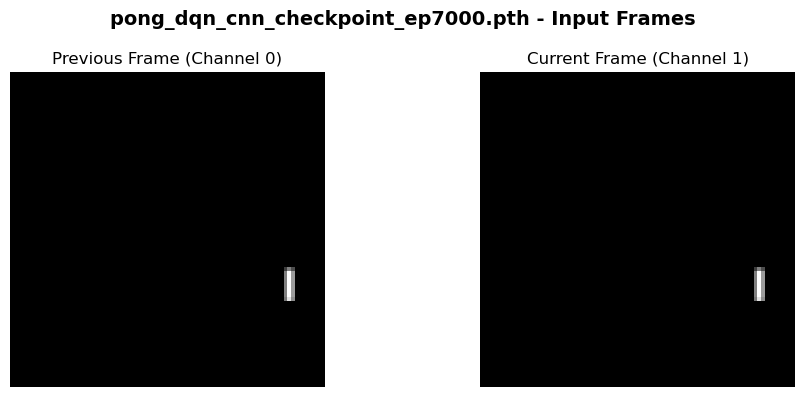

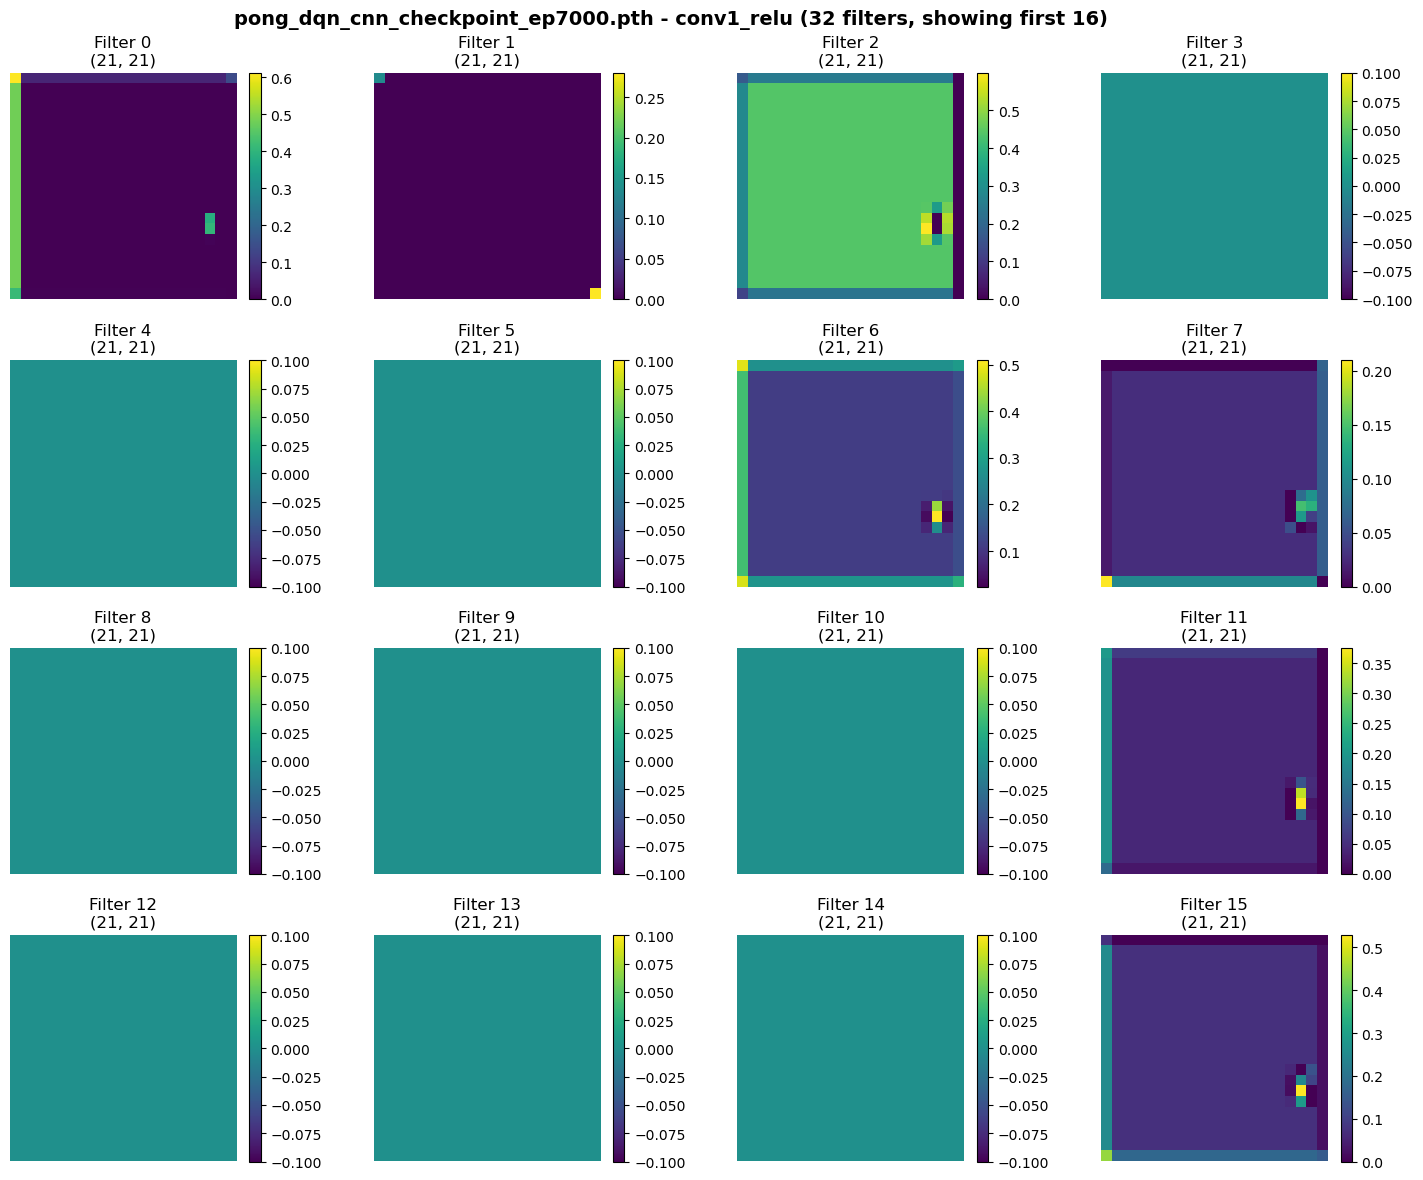

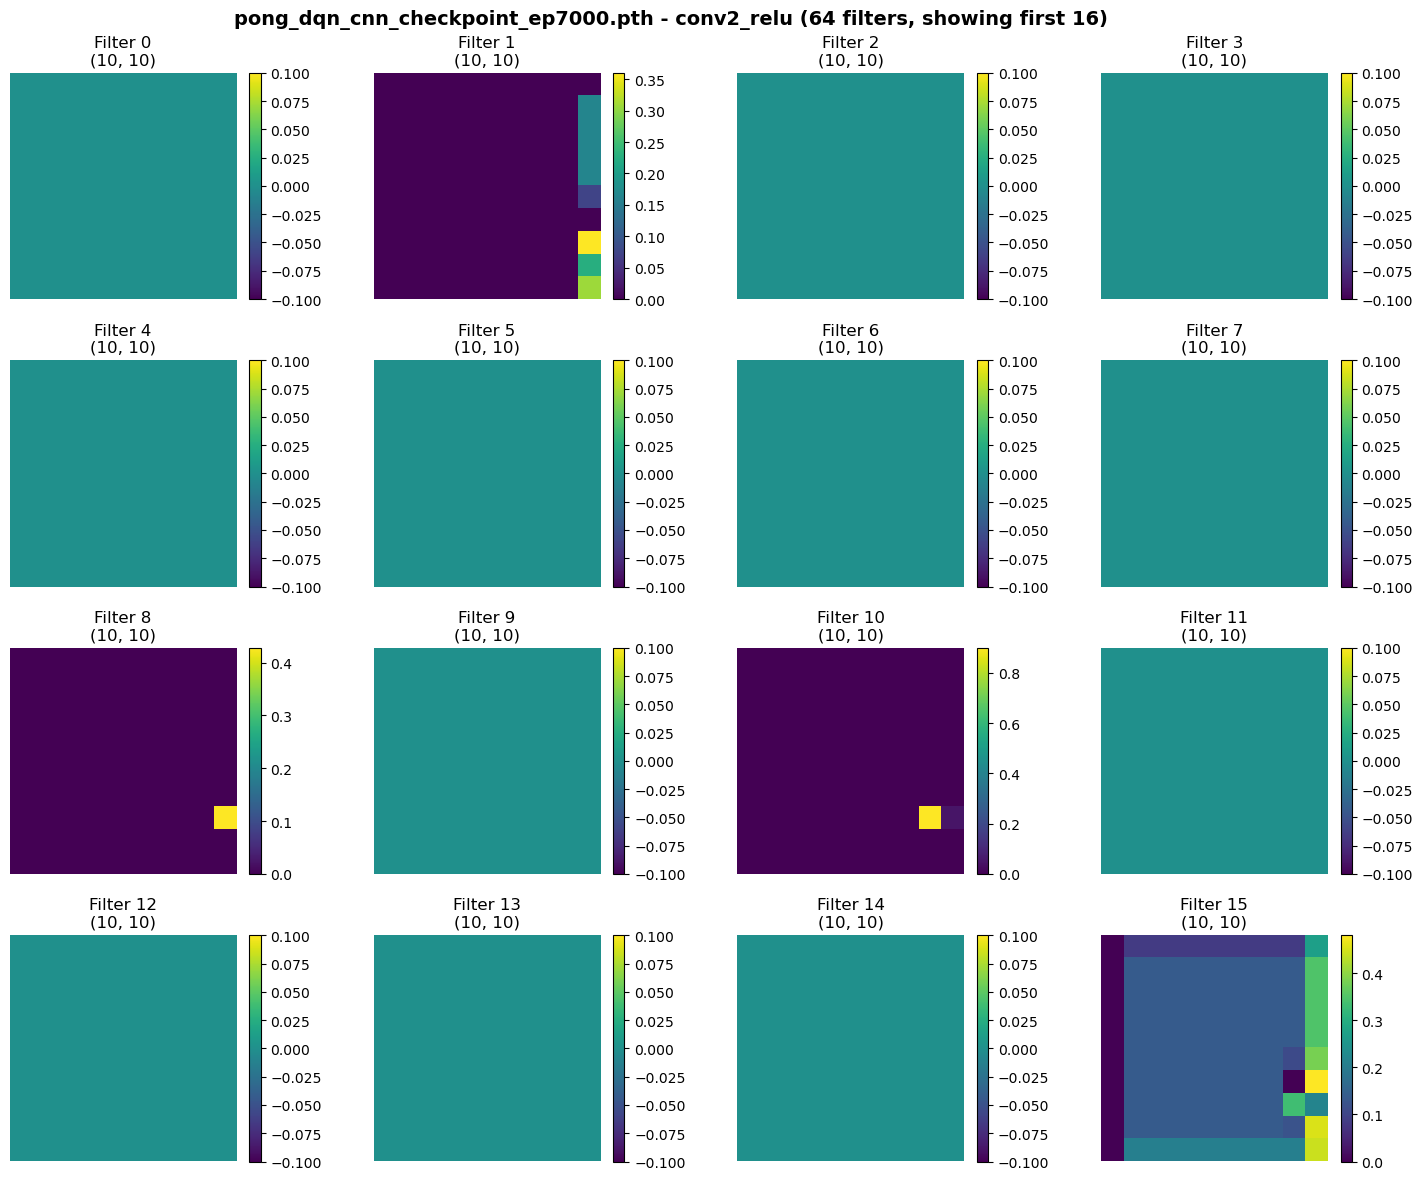

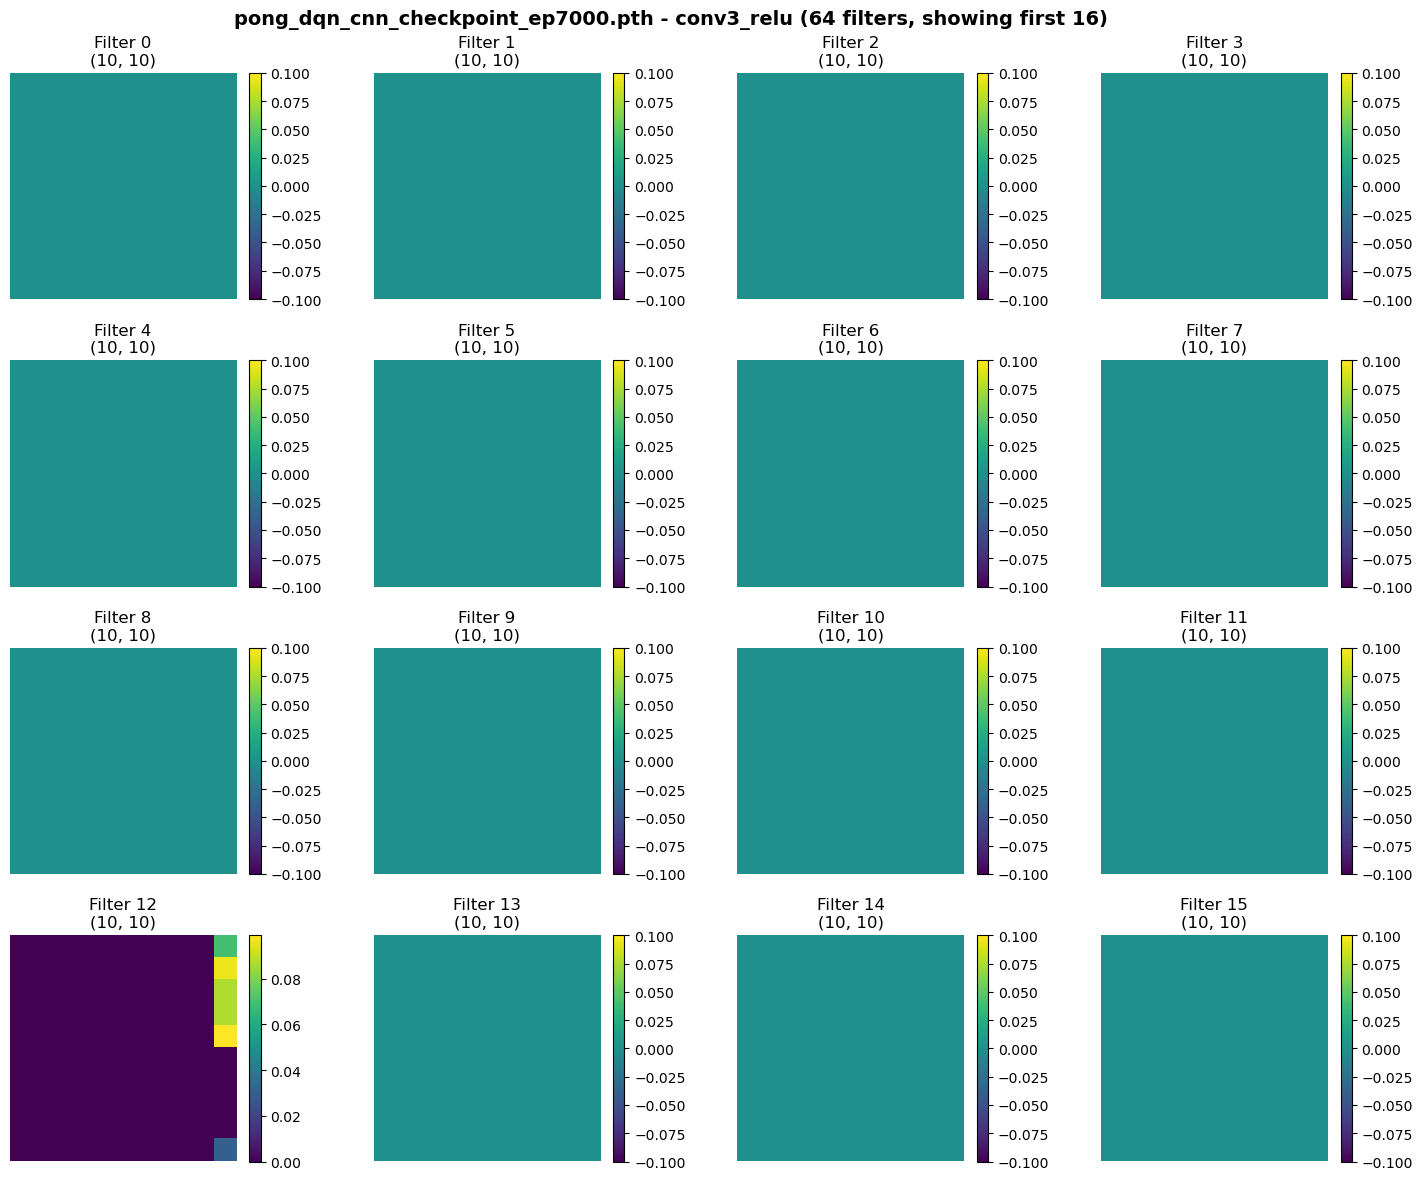


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.036 | Max:  0.943 | Sparsity: 0.783
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.009 | Max:  1.417 | Sparsity: 0.950
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.205 | Sparsity: 0.998

CHECKPOINT 8/8: pong_dqn_cnn_checkpoint_ep8000.pth
Training Episode: 8000
Training Avg Reward: -16.9

Visualizing layers for pong_dqn_cnn_checkpoint_ep8000.pth


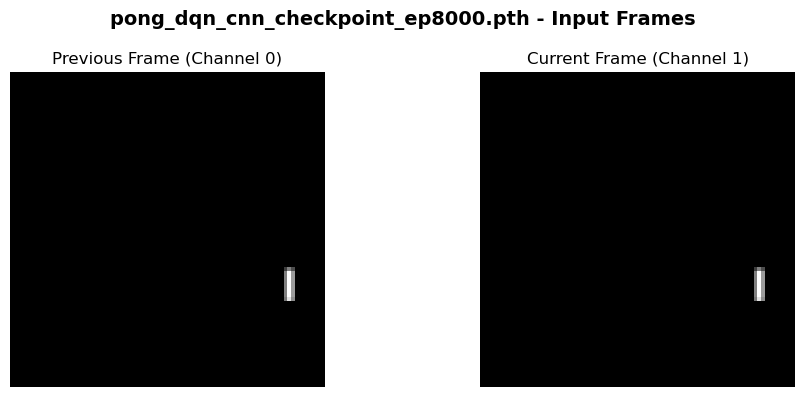

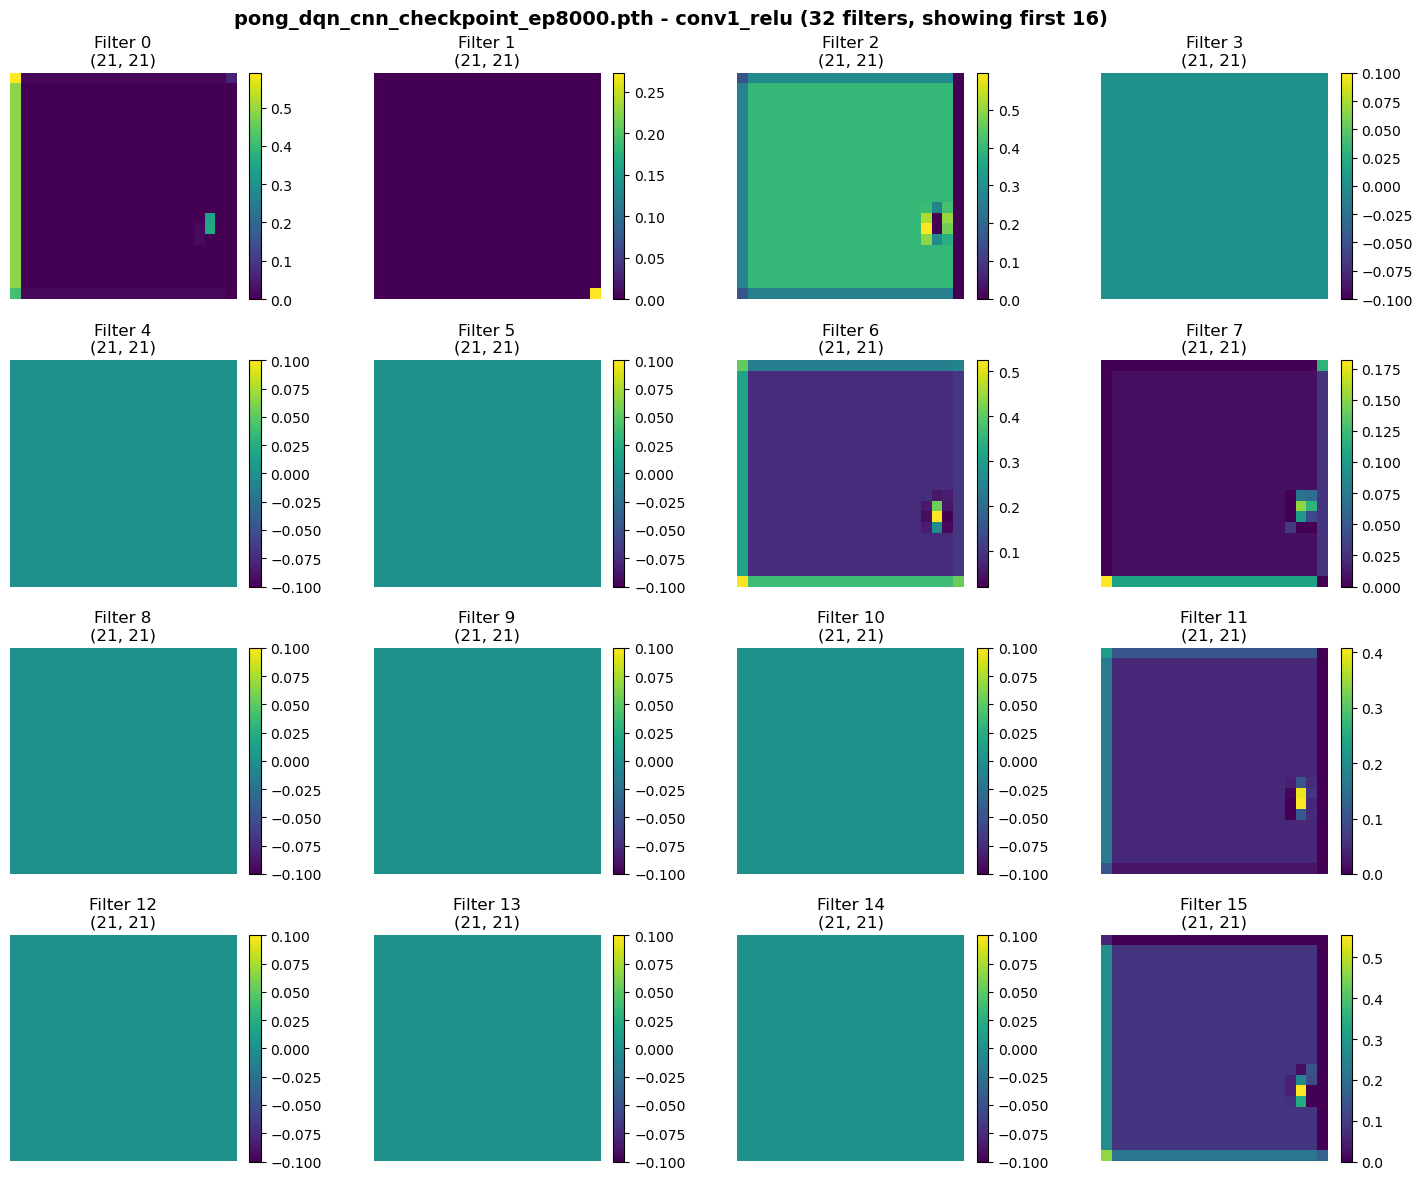

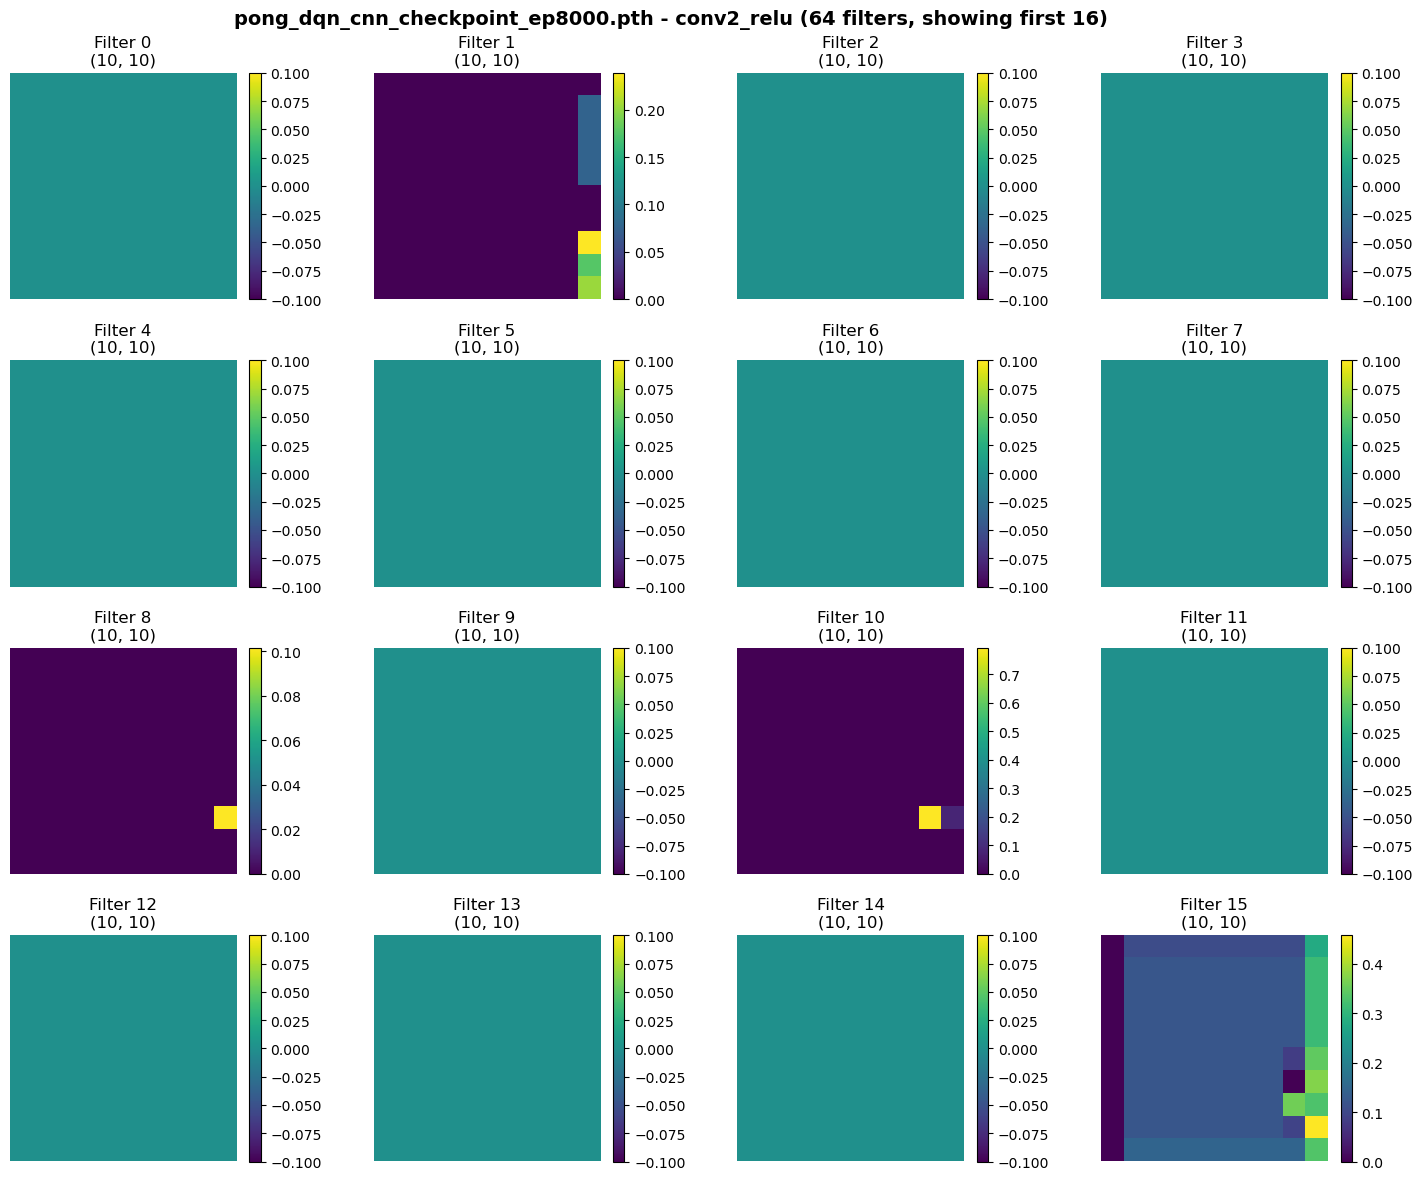

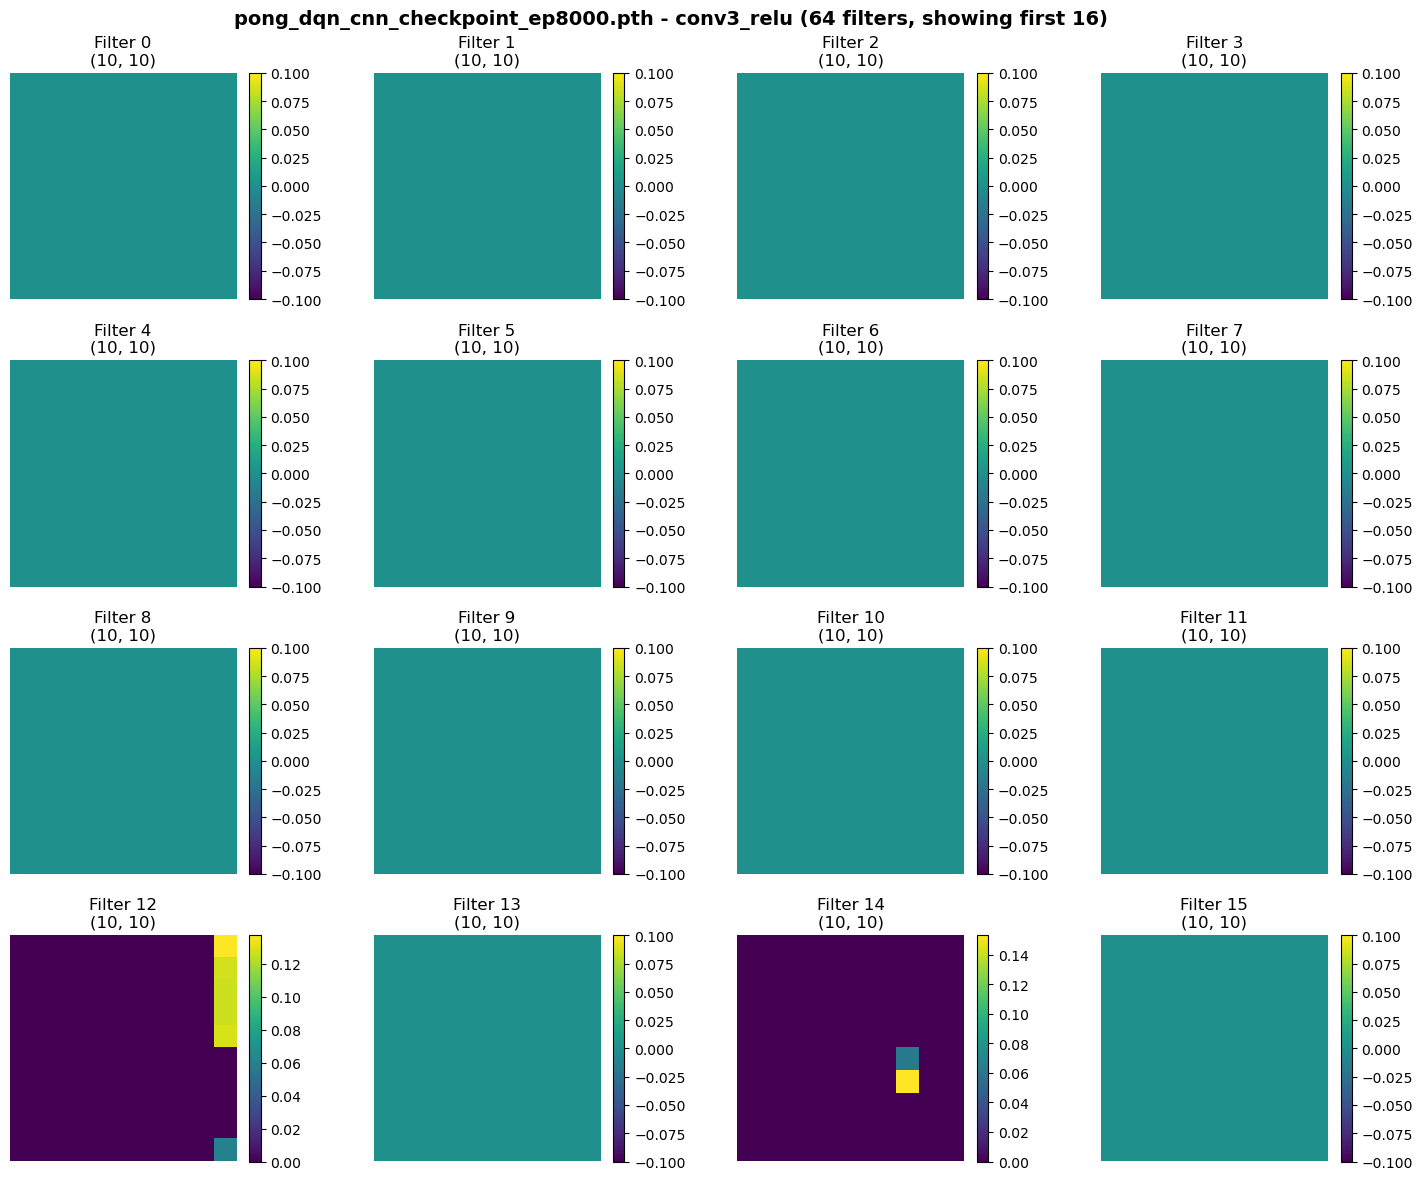


Layer Statistics:
conv1_relu   | Shape: torch.Size([1, 32, 21, 21]) | Mean:  0.033 | Max:  0.874 | Sparsity: 0.786
conv2_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.008 | Max:  1.440 | Sparsity: 0.950
conv3_relu   | Shape: torch.Size([1, 64, 10, 10]) | Mean:  0.000 | Max:  0.248 | Sparsity: 0.997


In [27]:
# Visualize CNN layers for all checkpoints
if checkpoints:
    # Convert stacked frame to tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = torch.FloatTensor(stacked_frame).unsqueeze(0).to(device)
    
    for i, checkpoint in enumerate(checkpoints):
        print(f"\n{'='*80}")
        print(f"CHECKPOINT {i+1}/{len(checkpoints)}: {checkpoint['filename']}")
        print(f"{'='*80}")
        
        try:
            # Load model
            model, metadata, device = load_model(checkpoint['path'])
            print(f"Training Episode: {metadata['episode']}")
            print(f"Training Avg Reward: {metadata['avg_reward']}")
            
            # Visualize layers
            visualize_all_layers(model, input_tensor, checkpoint['filename'])
            
        except Exception as e:
            print(f"Error with checkpoint {checkpoint['filename']}: {e}")
            continue
else:
    print("No checkpoints available to analyze!")

## Compare Layers Across Checkpoints


COMPARING FIRST CONVOLUTIONAL LAYER ACROSS CHECKPOINTS


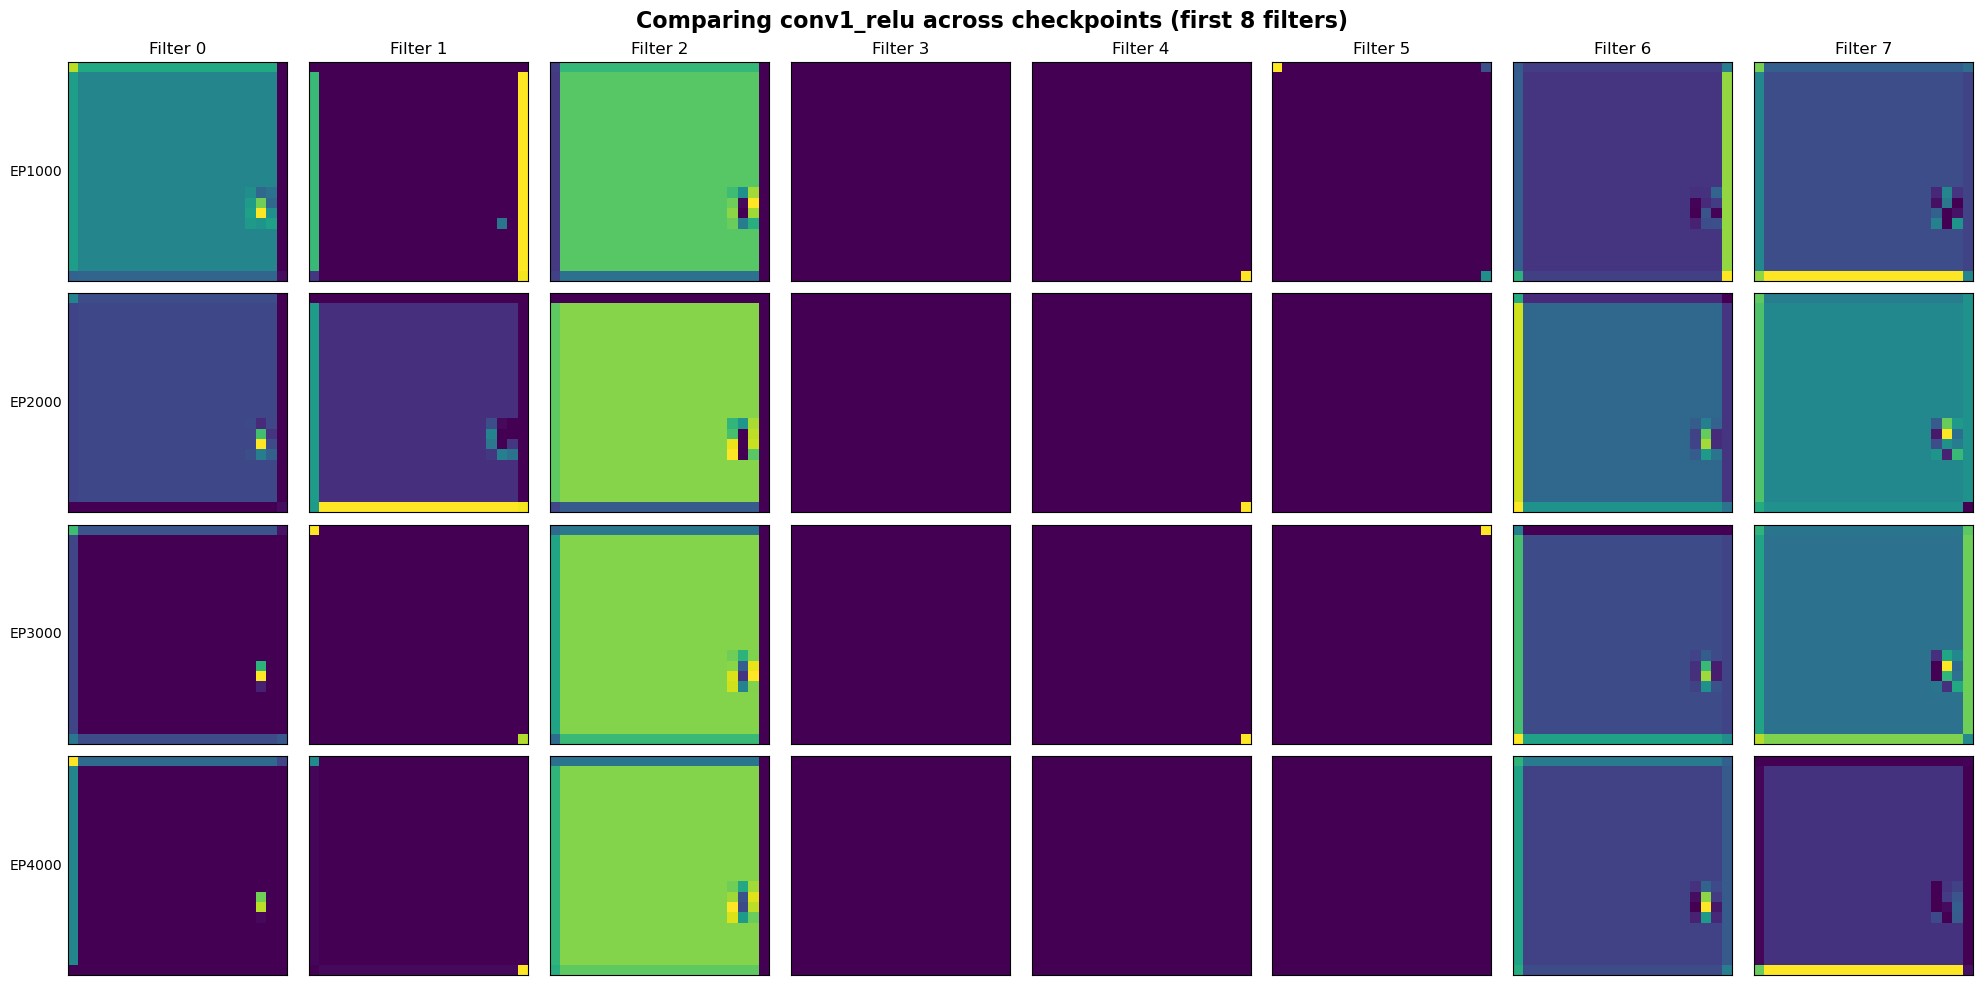

In [28]:
# Compare first convolutional layer across checkpoints
if checkpoints:
    print("\n" + "="*80)
    print("COMPARING FIRST CONVOLUTIONAL LAYER ACROSS CHECKPOINTS")
    print("="*80)
    compare_layer_across_checkpoints(checkpoints, stacked_frame, 'conv1_relu', max_checkpoints=4)
else:
    print("No checkpoints available for comparison!")


COMPARING SECOND CONVOLUTIONAL LAYER ACROSS CHECKPOINTS


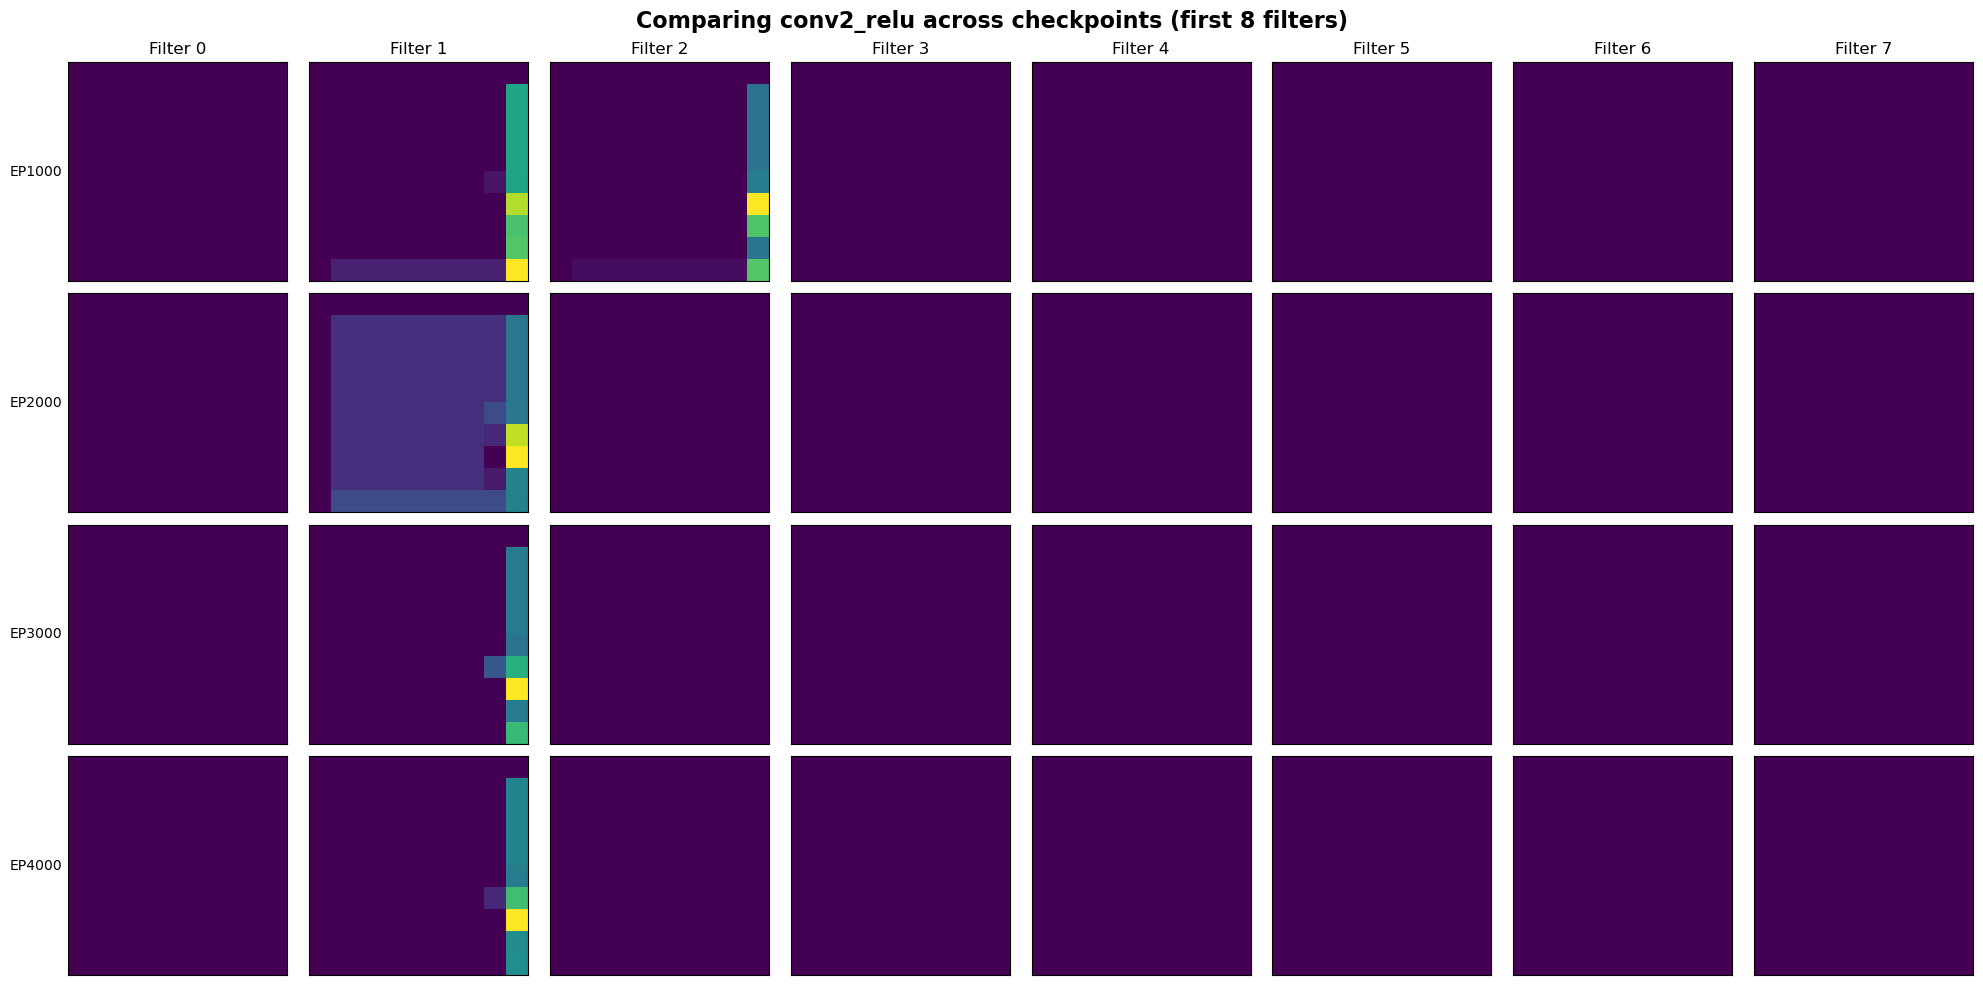

In [29]:
# Compare second convolutional layer across checkpoints
if checkpoints:
    print("\n" + "="*80)
    print("COMPARING SECOND CONVOLUTIONAL LAYER ACROSS CHECKPOINTS")
    print("="*80)
    compare_layer_across_checkpoints(checkpoints, stacked_frame, 'conv2_relu', max_checkpoints=4)
else:
    print("No checkpoints available for comparison!")


COMPARING THIRD CONVOLUTIONAL LAYER ACROSS CHECKPOINTS


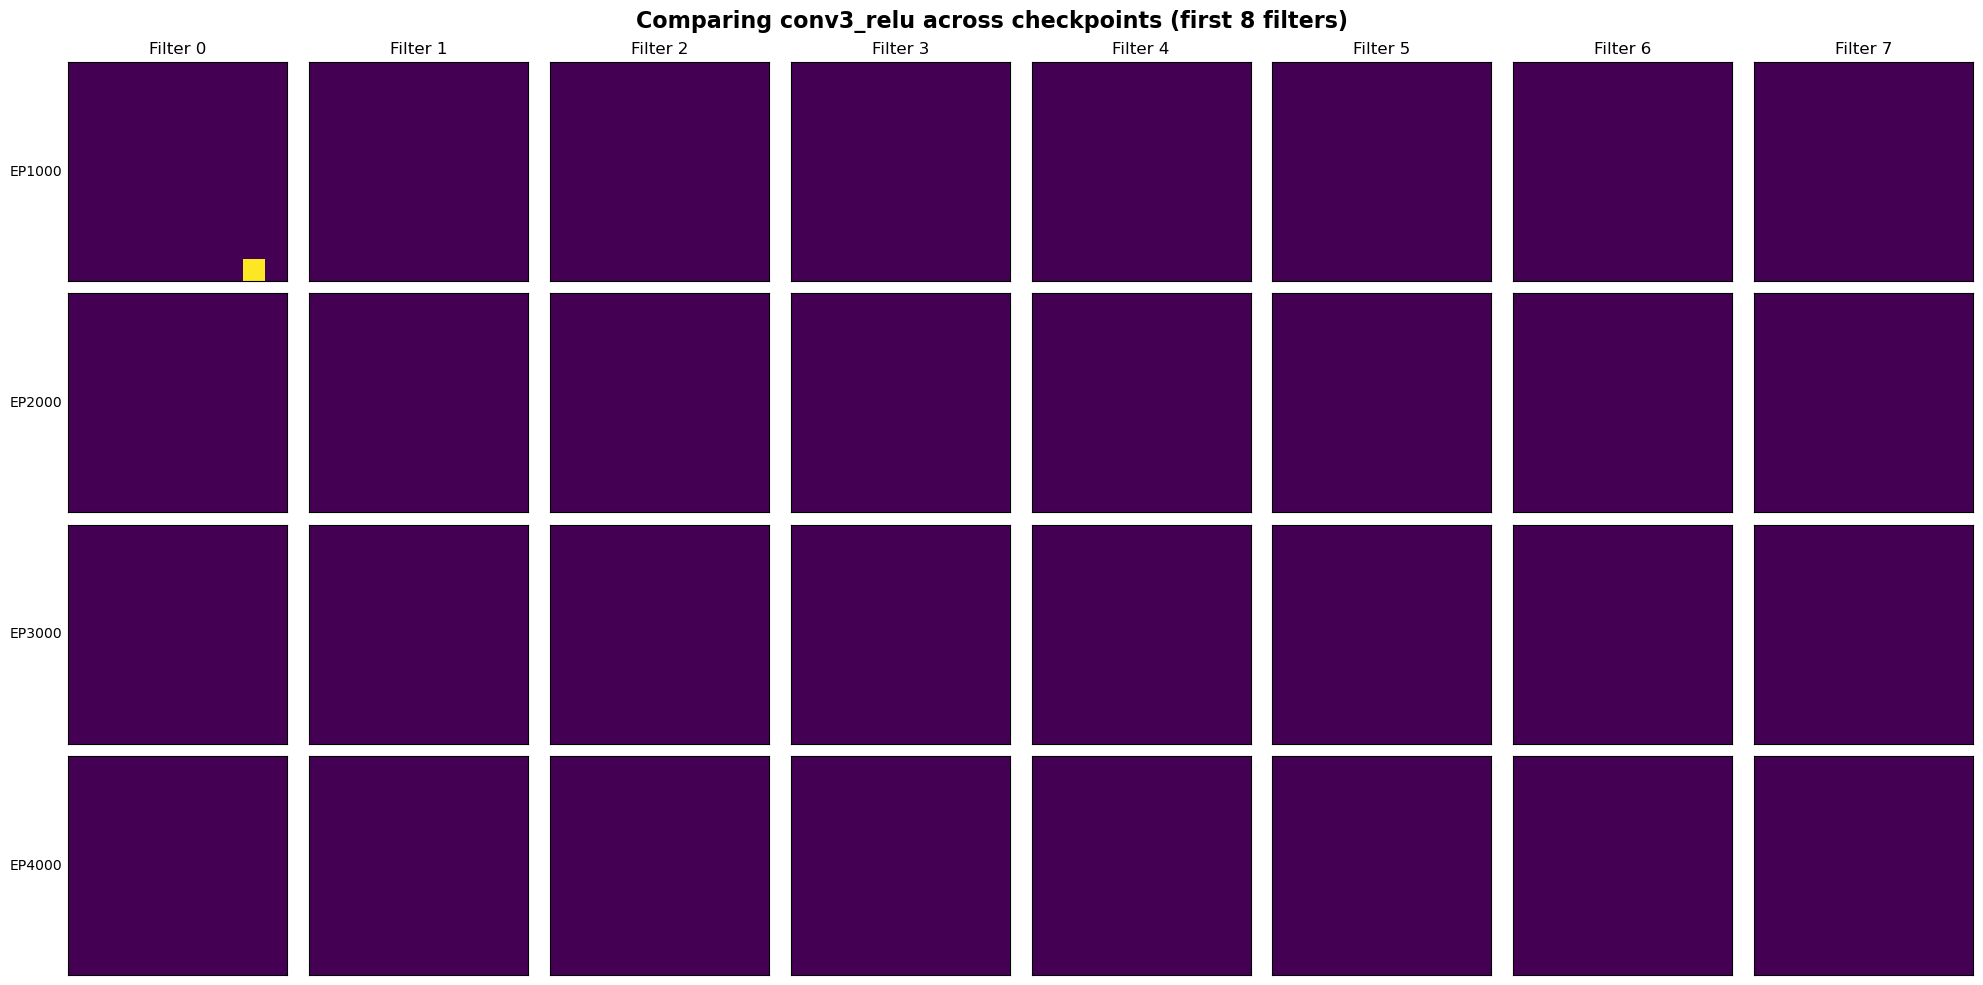

In [30]:
# Compare third convolutional layer across checkpoints
if checkpoints:
    print("\n" + "="*80)
    print("COMPARING THIRD CONVOLUTIONAL LAYER ACROSS CHECKPOINTS")
    print("="*80)
    compare_layer_across_checkpoints(checkpoints, stacked_frame, 'conv3_relu', max_checkpoints=4)
else:
    print("No checkpoints available for comparison!")